In [1]:
import torch, pickle, time, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Import Data

In [2]:
file = open('data-250-125.pkl', 'rb')
df = pickle.load(file)
file.close()

In [3]:
df.head()

,subject,day,session,motion,repetition,window_emg
0,sub03,D3,S1,OH,1,"[[0.4140625, 0.6015625, -0.203125, -0.2109375,..."
1,sub03,D3,S1,OH,1,"[[0.2421875, -0.0546875, -0.0078125, 0.015625,..."
2,sub03,D3,S1,OH,1,"[[-0.5546875, -0.125, -0.0625, -0.0234375, -0...."
3,sub03,D3,S1,OH,1,"[[-0.1953125, -0.0625, -0.265625, -0.0234375, ..."
4,sub03,D3,S1,OH,1,"[[0.0703125, -0.1484375, 0.171875, -0.015625, ..."


In [4]:
df.shape

(585900, 6)

In [5]:
df.subject.value_counts()

subject
sub03    83700
sub04    83700
sub05    83700
sub02    83700
sub07    83700
sub01    83700
sub06    83700
Name: count, dtype: int64

## Preprocessing Data

### Filter only 7 Motions

In [6]:
df = df[~df.motion.isin(['IN', 'GR'])]

In [7]:
df.motion.value_counts()

motion
OH    65100
CH    65100
EX    65100
FL    65100
SU    65100
PR    65100
RT    65100
Name: count, dtype: int64

### Change Labels into Numerics

In [8]:
df['label'] = df.motion.replace(
    df.motion.drop_duplicates().tolist(),
    [i for i in range(7)]
)

/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_18917/480921104.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.motion.replace(


In [9]:
df.subject.value_counts()

subject
sub03    65100
sub04    65100
sub05    65100
sub02    65100
sub07    65100
sub01    65100
sub06    65100
Name: count, dtype: int64

### Create Subset DF for Initial Training

In [7]:
random.seed(42)
picked_subs = random.sample(df.subject.unique().tolist(), 2)
df_min = df[df.subject.isin(picked_subs)]

In [8]:
df_min1 = df_min[df_min.subject == picked_subs[0]]
df_min2 = df_min[df_min.subject == picked_subs[1]]

In [9]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df_min1,
                                                        df_min1.label.to_numpy(), 
                                                        test_size=.1, 
                                                        random_state=42)

In [10]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df_min2,
                                                        df_min2.label.to_numpy(), 
                                                        test_size=.1, 
                                                        random_state=42)

In [11]:
device = 'mps'

In [12]:
X1_train_tensor = torch.FloatTensor(np.stack(X1_train.window_emg.to_numpy())).to(device)
X1_test_tensor = torch.FloatTensor(np.stack(X1_test.window_emg.to_numpy())).to(device)
y1_train = torch.FloatTensor(y1_train).to(device).to(device)
y1_test = torch.FloatTensor(y1_test).to(device).to(device)

In [13]:
X2_train_tensor = torch.FloatTensor(np.stack(X2_train.window_emg.to_numpy())).to(device)
X2_test_tensor = torch.FloatTensor(np.stack(X2_test.window_emg.to_numpy())).to(device)
y2_train = torch.FloatTensor(y2_train).to(device).to(device)
y2_test = torch.FloatTensor(y2_test).to(device).to(device)

In [14]:
train1_set = TensorDataset(X1_train_tensor, y1_train)
val1_set = TensorDataset(X1_test_tensor, y1_test)

In [15]:
train2_set = TensorDataset(X2_train_tensor, y2_train)
val2_set = TensorDataset(X2_test_tensor, y2_test)

## Building Model Architecture

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=8, num_classes=7, hidden_size=128, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        
        return out

## Pre-Evaluation Training

### Training Function

In [8]:
def train_model(model, train_set, val_set, criterion, optimizer, num_epochs=15, batch_size=64, verbose=True):
    device = 'mps'
    model.to(device)
    train_loader = DataLoader(train_set, batch_size=batch_size)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    train_loss = list()
    train_acc = list()
    val_loss = list()
    val_acc = list()
    train_times = list()
    inf_times = list()

    for epoch in range(num_epochs):
        start_epoch = time.time()
        model.train()
        train_total_loss = 0
        total = 0
        correct = 0

        start = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()
        ttime = (time.time() - start) * 1e6 # in microsecond
        train_times.append(ttime)

        # Keep tab on the train loss every epoch
        train_loss.append(train_total_loss / len(train_loader))
        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        model.eval()
        correct = 0
        total = 0
        val_total_loss = 0

        start = time.time()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        itime = (time.time() - start) * 1e6 # in microsecond
        inf_times.append(itime)

        val_loss.append(val_total_loss / len(val_loader))

        val_accuracy = 100 * correct / total
        val_acc.append(val_accuracy)

        if verbose:
            etime = (time.time() - start_epoch) * 1e3
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Epoch Time: {etime:.4f}ms')
        
    avg_train_time = np.mean(train_times)
    avg_inf_time = np.mean(inf_times)

    return model, train_loss, train_acc, val_loss, val_acc, avg_train_time, avg_inf_time

### Architecture 1: Layer=1, Hidden=32

In [24]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 21.03%, Validation Accuracy: 32.61%, Epoch Time: 5832.9809ms
Epoch [2/15], Train Accuracy: 39.02%, Validation Accuracy: 49.92%, Epoch Time: 5579.1328ms
Epoch [3/15], Train Accuracy: 58.50%, Validation Accuracy: 58.25%, Epoch Time: 5577.8100ms
Epoch [4/15], Train Accuracy: 67.93%, Validation Accuracy: 72.44%, Epoch Time: 5636.9901ms
Epoch [5/15], Train Accuracy: 70.91%, Validation Accuracy: 73.70%, Epoch Time: 5613.2309ms
Epoch [6/15], Train Accuracy: 78.54%, Validation Accuracy: 89.25%, Epoch Time: 5557.7159ms
Epoch [7/15], Train Accuracy: 82.18%, Validation Accuracy: 86.04%, Epoch Time: 5592.4993ms
Epoch [8/15], Train Accuracy: 86.97%, Validation Accuracy: 88.76%, Epoch Time: 5592.5298ms
Epoch [9/15], Train Accuracy: 88.98%, Validation Accuracy: 89.94%, Epoch Time: 5518.9528ms
Epoch [10/15], Train Accuracy: 89.43%, Validation Accuracy: 91.04%, Epoch Time: 5696.3420ms
Epoch [11/15], Train Accuracy: 76.79%, Validation Accuracy: 76.88%,

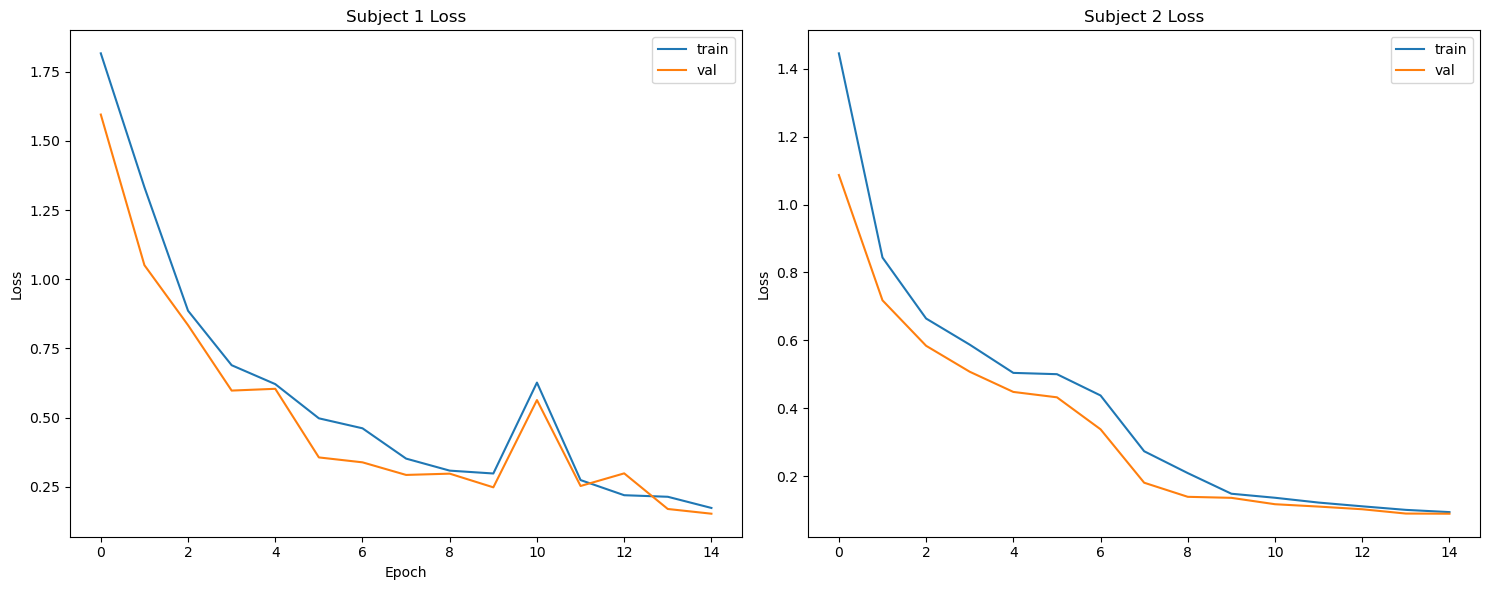

In [25]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

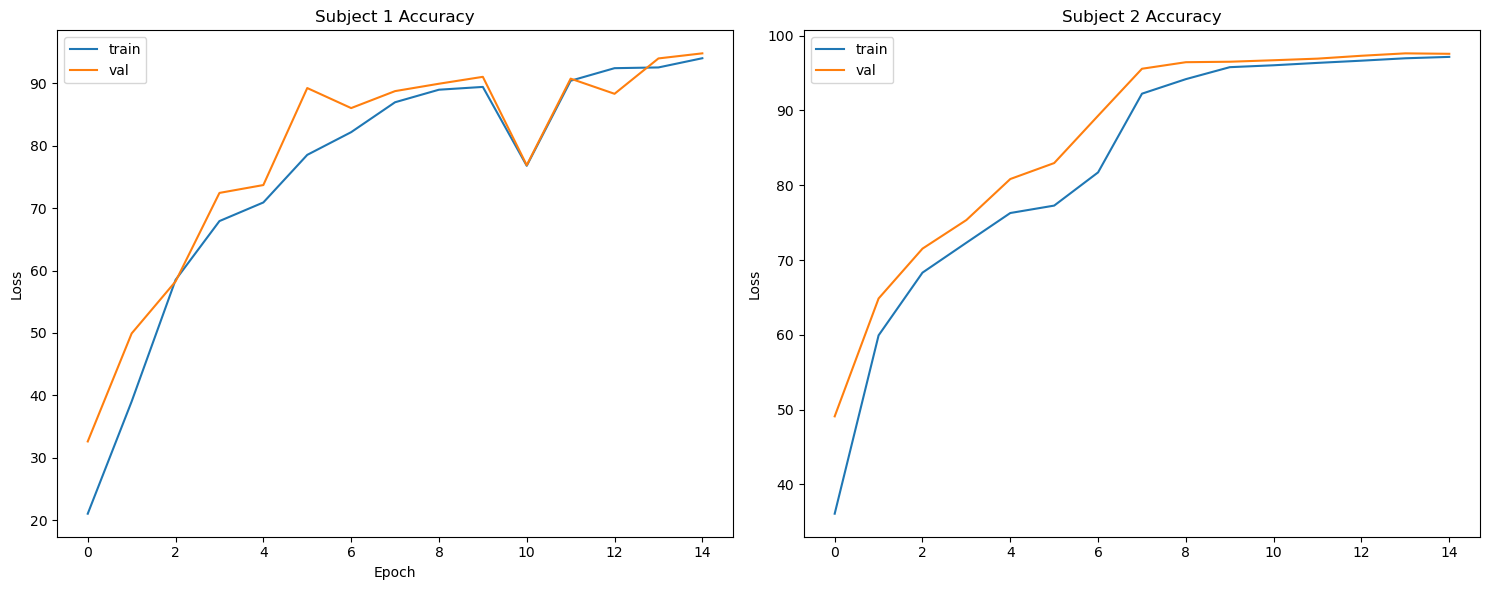

In [26]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 2: Layer=1, Hidden=16

In [27]:
hidden_size = 16

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 21.47%, Validation Accuracy: 34.87%, Epoch Time: 6115.0420ms
Epoch [2/15], Train Accuracy: 43.32%, Validation Accuracy: 57.43%, Epoch Time: 5711.8049ms
Epoch [3/15], Train Accuracy: 59.35%, Validation Accuracy: 43.26%, Epoch Time: 5703.4650ms
Epoch [4/15], Train Accuracy: 65.92%, Validation Accuracy: 69.89%, Epoch Time: 5635.6909ms
Epoch [5/15], Train Accuracy: 68.90%, Validation Accuracy: 74.06%, Epoch Time: 5656.4078ms
Epoch [6/15], Train Accuracy: 70.59%, Validation Accuracy: 74.64%, Epoch Time: 5560.5607ms
Epoch [7/15], Train Accuracy: 72.75%, Validation Accuracy: 75.24%, Epoch Time: 5594.4948ms
Epoch [8/15], Train Accuracy: 74.64%, Validation Accuracy: 74.35%, Epoch Time: 5574.7218ms
Epoch [9/15], Train Accuracy: 77.83%, Validation Accuracy: 82.84%, Epoch Time: 5666.4093ms
Epoch [10/15], Train Accuracy: 83.70%, Validation Accuracy: 85.84%, Epoch Time: 5609.7291ms
Epoch [11/15], Train Accuracy: 86.38%, Validation Accuracy: 87.47%,

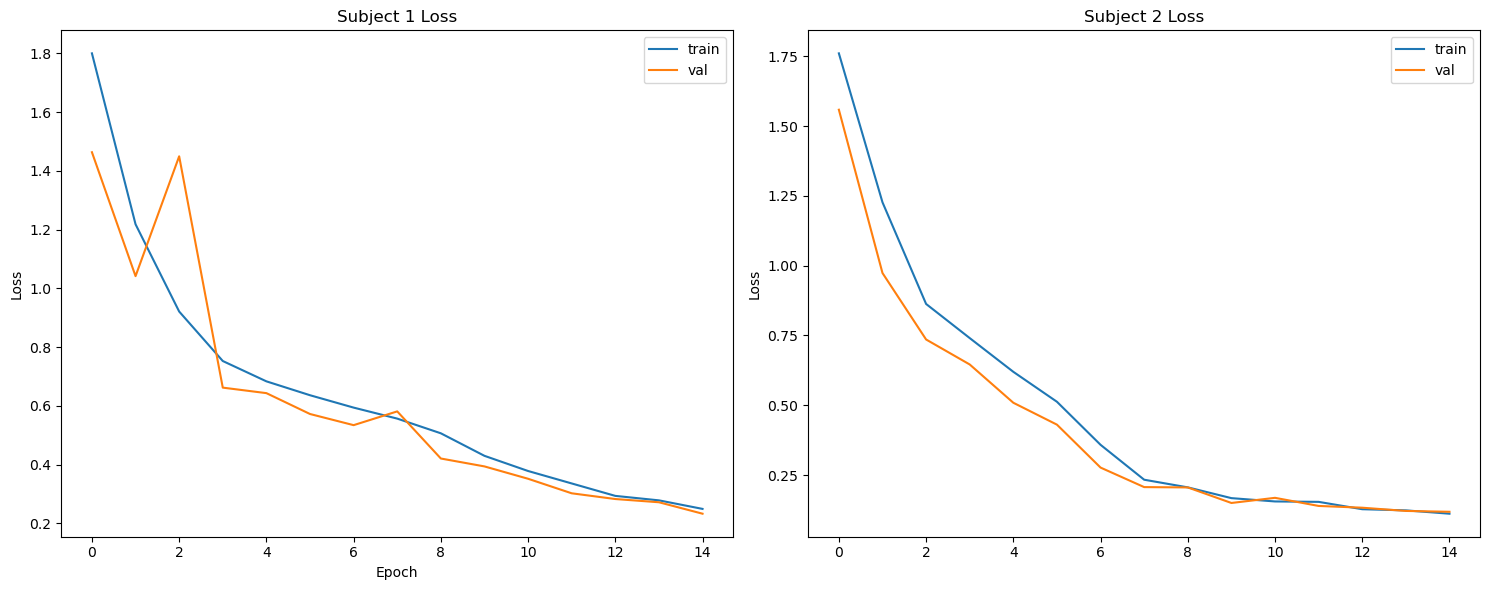

In [28]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

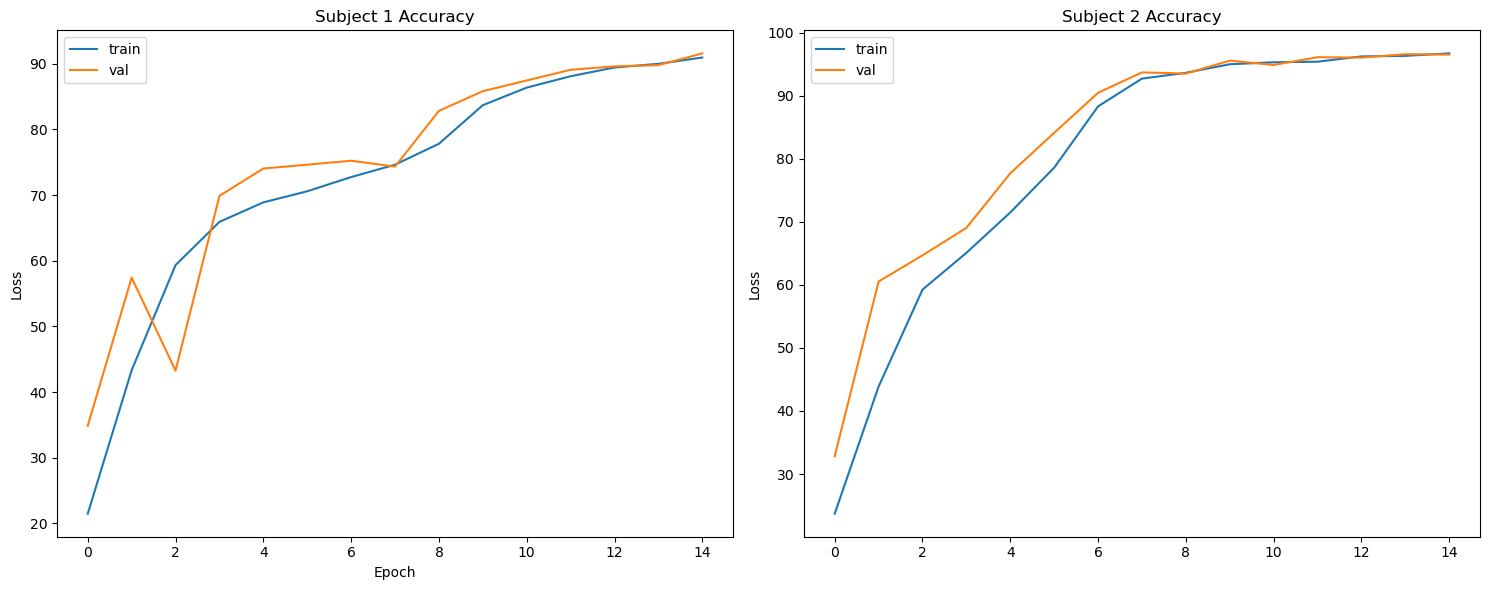

In [29]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 3: Layer=1, Hidden=64

In [30]:
hidden_size = 64

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 23.91%, Validation Accuracy: 48.96%, Epoch Time: 6166.7669ms
Epoch [2/15], Train Accuracy: 55.29%, Validation Accuracy: 61.80%, Epoch Time: 5726.9709ms
Epoch [3/15], Train Accuracy: 70.66%, Validation Accuracy: 71.72%, Epoch Time: 5740.4110ms
Epoch [4/15], Train Accuracy: 73.75%, Validation Accuracy: 75.78%, Epoch Time: 5581.2979ms
Epoch [5/15], Train Accuracy: 83.41%, Validation Accuracy: 88.16%, Epoch Time: 5580.3239ms
Epoch [6/15], Train Accuracy: 88.85%, Validation Accuracy: 91.14%, Epoch Time: 5578.0880ms
Epoch [7/15], Train Accuracy: 91.00%, Validation Accuracy: 91.08%, Epoch Time: 5625.3309ms
Epoch [8/15], Train Accuracy: 92.87%, Validation Accuracy: 92.21%, Epoch Time: 5594.0821ms
Epoch [9/15], Train Accuracy: 94.03%, Validation Accuracy: 93.39%, Epoch Time: 5588.0489ms
Epoch [10/15], Train Accuracy: 94.60%, Validation Accuracy: 94.88%, Epoch Time: 5576.2160ms
Epoch [11/15], Train Accuracy: 94.51%, Validation Accuracy: 91.49%,

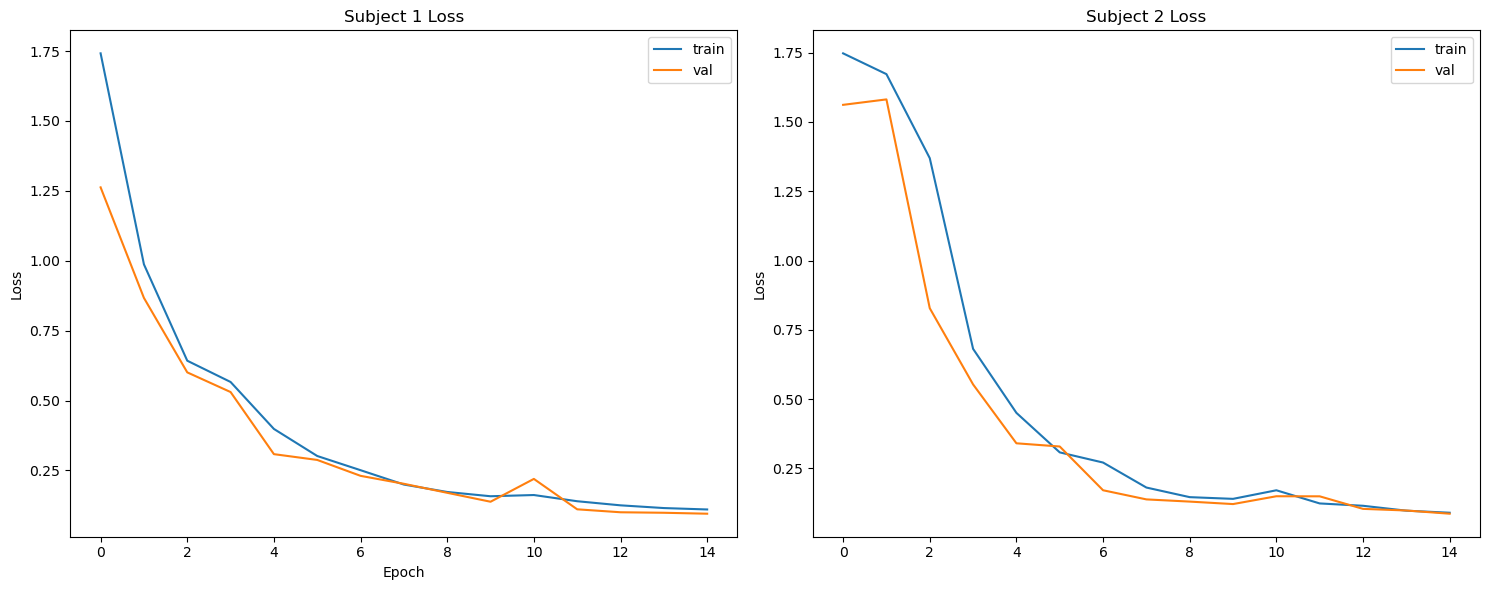

In [31]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

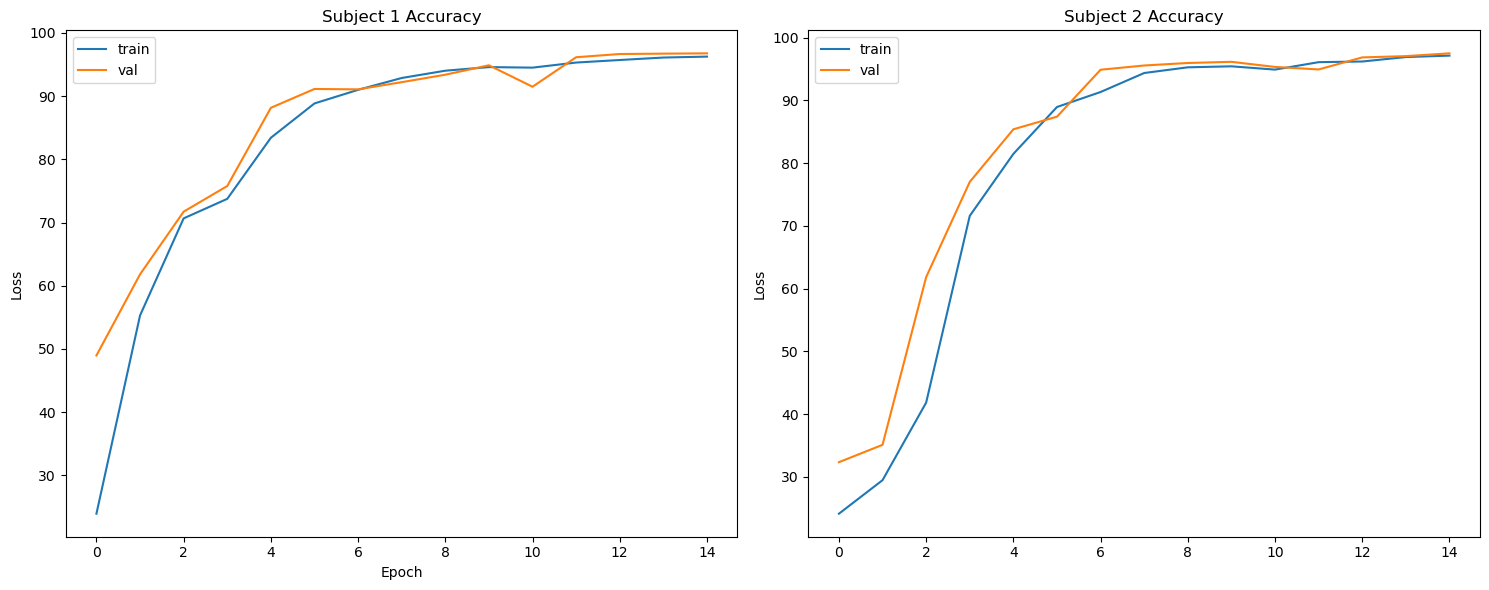

In [32]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 4: Layer=1, Hidden=128

In [33]:
hidden_size = 128

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 16.57%, Validation Accuracy: 28.00%, Epoch Time: 6630.3248ms
Epoch [2/15], Train Accuracy: 29.17%, Validation Accuracy: 36.68%, Epoch Time: 5894.8081ms
Epoch [3/15], Train Accuracy: 34.27%, Validation Accuracy: 49.54%, Epoch Time: 5803.3822ms
Epoch [4/15], Train Accuracy: 58.85%, Validation Accuracy: 72.00%, Epoch Time: 5792.1689ms
Epoch [5/15], Train Accuracy: 74.64%, Validation Accuracy: 81.84%, Epoch Time: 5777.3180ms
Epoch [6/15], Train Accuracy: 82.69%, Validation Accuracy: 87.77%, Epoch Time: 5885.1438ms
Epoch [7/15], Train Accuracy: 88.86%, Validation Accuracy: 90.43%, Epoch Time: 5827.3423ms
Epoch [8/15], Train Accuracy: 90.92%, Validation Accuracy: 92.41%, Epoch Time: 5778.6911ms
Epoch [9/15], Train Accuracy: 93.05%, Validation Accuracy: 93.75%, Epoch Time: 5808.4629ms
Epoch [10/15], Train Accuracy: 94.16%, Validation Accuracy: 95.04%, Epoch Time: 5819.8829ms
Epoch [11/15], Train Accuracy: 95.09%, Validation Accuracy: 96.19%,

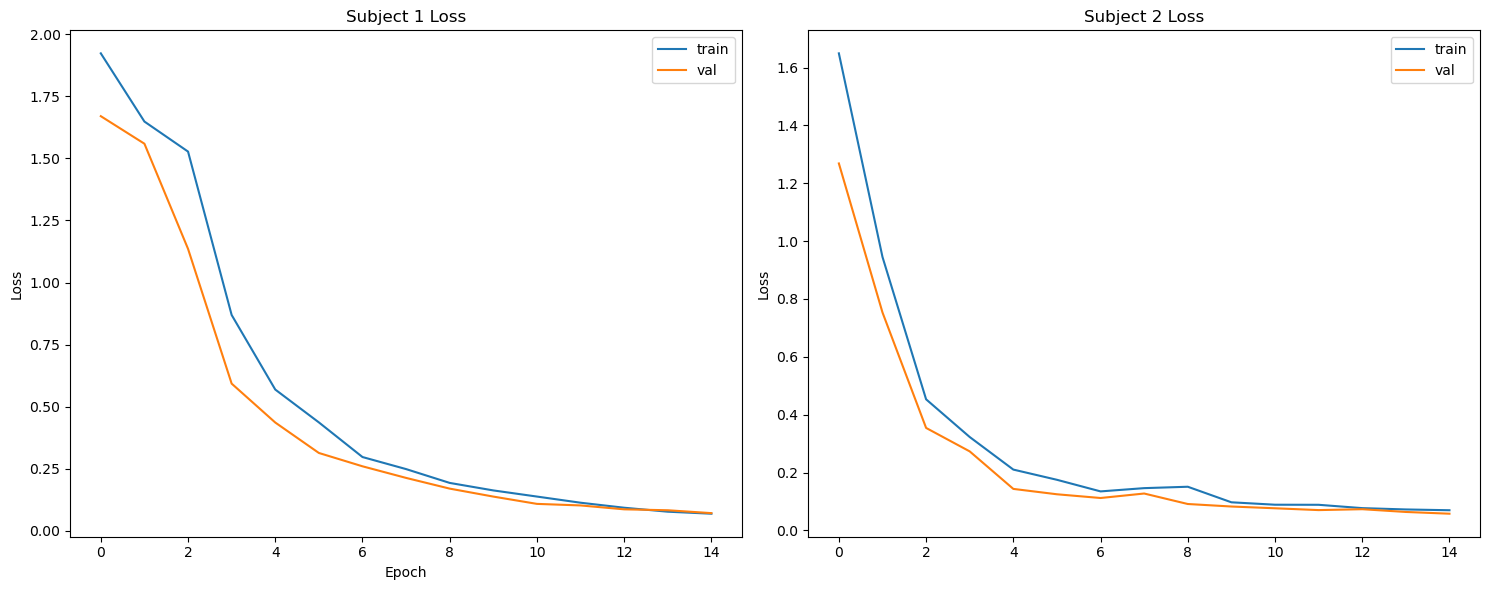

In [34]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

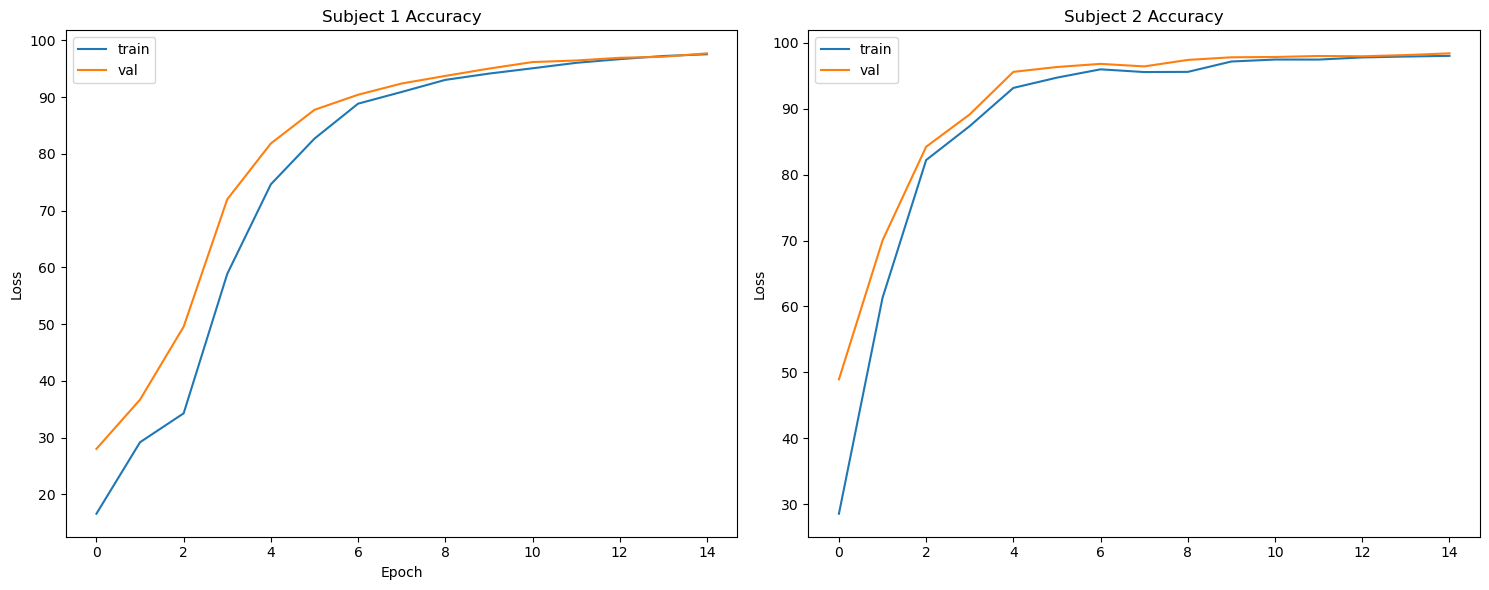

In [35]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 5: Layer=1, Hidden=256

In [36]:
hidden_size = 256

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 20.08%, Validation Accuracy: 14.13%, Epoch Time: 8626.8919ms
Epoch [2/15], Train Accuracy: 15.35%, Validation Accuracy: 17.22%, Epoch Time: 8123.0128ms
Epoch [3/15], Train Accuracy: 26.62%, Validation Accuracy: 32.92%, Epoch Time: 8072.4208ms
Epoch [4/15], Train Accuracy: 40.01%, Validation Accuracy: 38.63%, Epoch Time: 8053.9179ms
Epoch [5/15], Train Accuracy: 54.66%, Validation Accuracy: 59.49%, Epoch Time: 8067.9109ms
Epoch [6/15], Train Accuracy: 65.21%, Validation Accuracy: 74.84%, Epoch Time: 8121.3641ms
Epoch [7/15], Train Accuracy: 73.73%, Validation Accuracy: 79.69%, Epoch Time: 8060.6041ms
Epoch [8/15], Train Accuracy: 83.92%, Validation Accuracy: 89.14%, Epoch Time: 8055.2671ms
Epoch [9/15], Train Accuracy: 91.04%, Validation Accuracy: 92.12%, Epoch Time: 8051.2969ms
Epoch [10/15], Train Accuracy: 93.06%, Validation Accuracy: 92.57%, Epoch Time: 8067.4629ms
Epoch [11/15], Train Accuracy: 95.03%, Validation Accuracy: 94.65%,

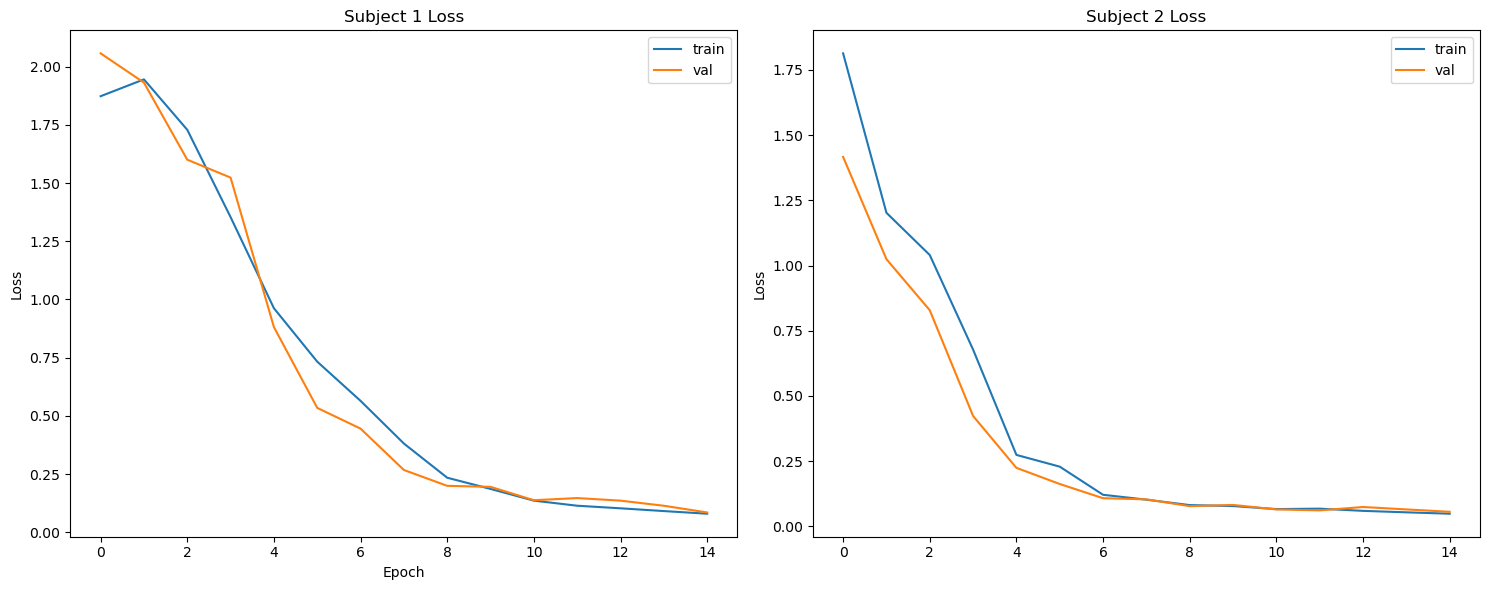

In [37]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

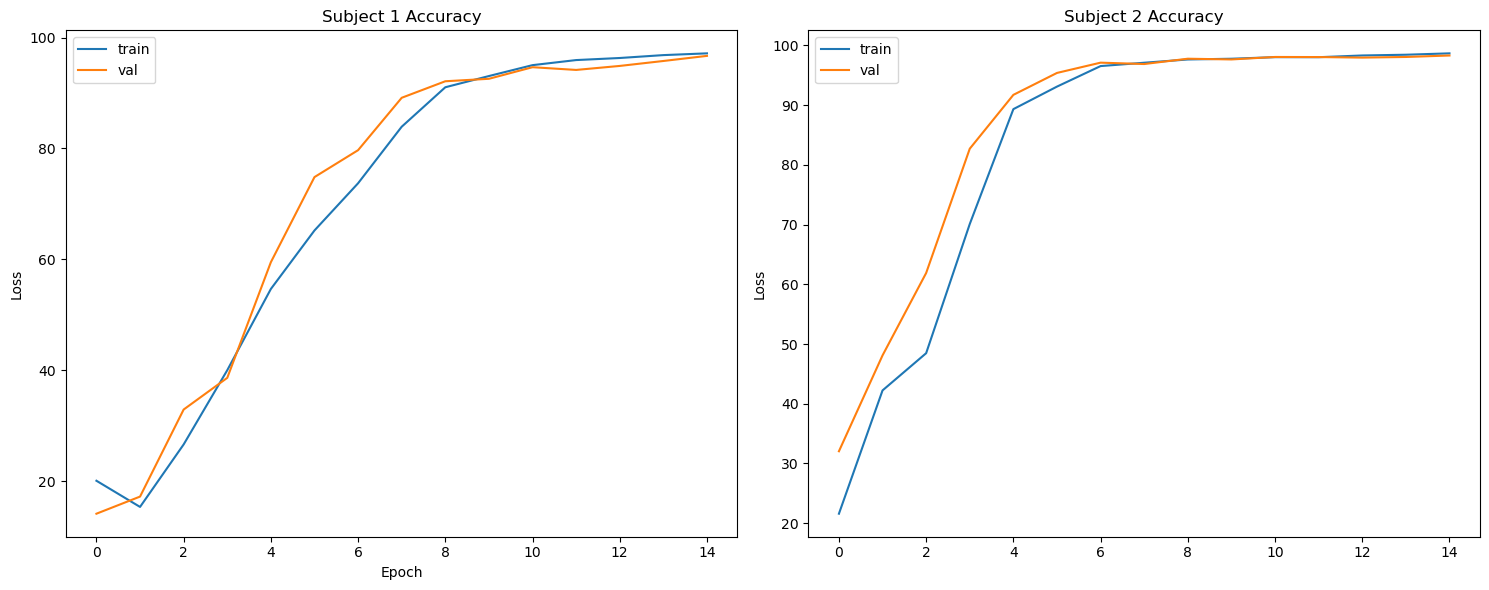

In [38]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6: Layer=2, Hidden=128

In [18]:
hidden_size = 128
num_layers = 2

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 24.44%, Validation Accuracy: 35.51%, Epoch Time: 9300.4398ms
Epoch [2/15], Train Accuracy: 39.27%, Validation Accuracy: 57.37%, Epoch Time: 9043.6862ms
Epoch [3/15], Train Accuracy: 62.76%, Validation Accuracy: 74.84%, Epoch Time: 8959.4152ms
Epoch [4/15], Train Accuracy: 82.76%, Validation Accuracy: 89.82%, Epoch Time: 9073.3609ms
Epoch [5/15], Train Accuracy: 92.65%, Validation Accuracy: 93.89%, Epoch Time: 8976.2630ms
Epoch [6/15], Train Accuracy: 95.59%, Validation Accuracy: 96.48%, Epoch Time: 8951.4449ms
Epoch [7/15], Train Accuracy: 96.65%, Validation Accuracy: 96.94%, Epoch Time: 8986.3980ms
Epoch [8/15], Train Accuracy: 97.05%, Validation Accuracy: 96.96%, Epoch Time: 8959.1632ms
Epoch [9/15], Train Accuracy: 97.51%, Validation Accuracy: 97.33%, Epoch Time: 8849.8871ms
Epoch [10/15], Train Accuracy: 97.78%, Validation Accuracy: 97.85%, Epoch Time: 9181.1273ms
Epoch [11/15], Train Accuracy: 97.95%, Validation Accuracy: 98.03%,

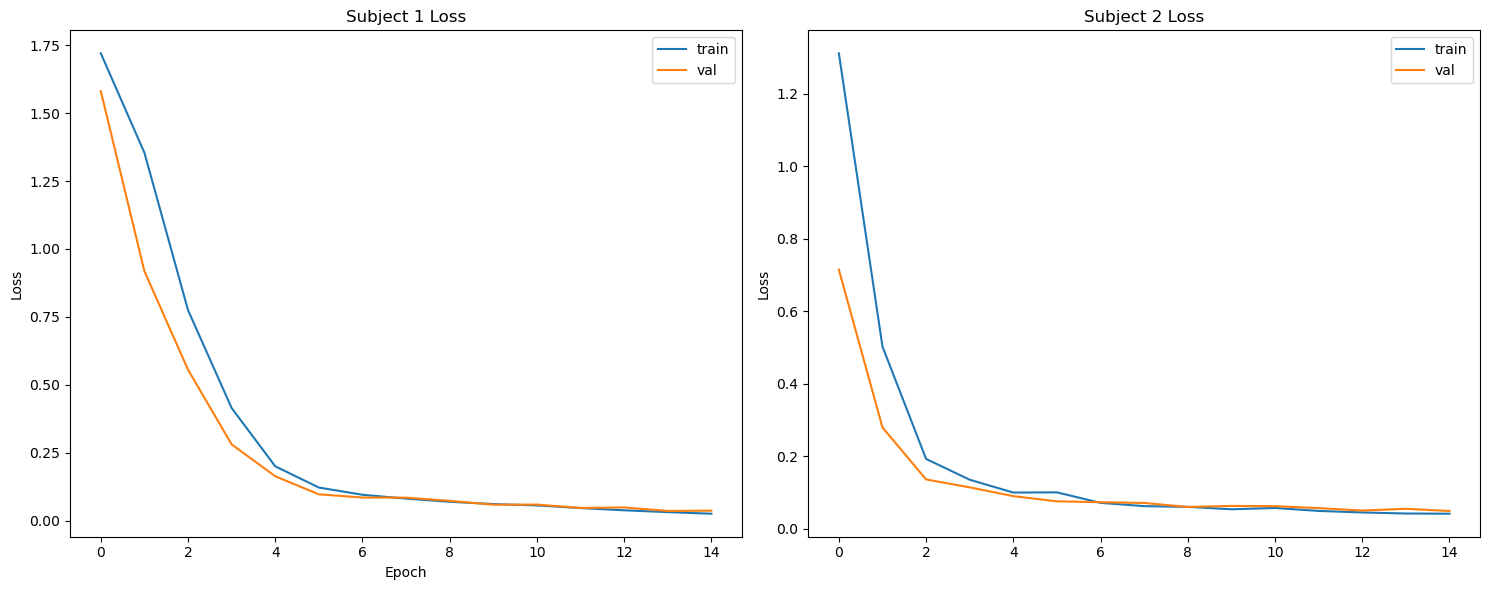

In [19]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

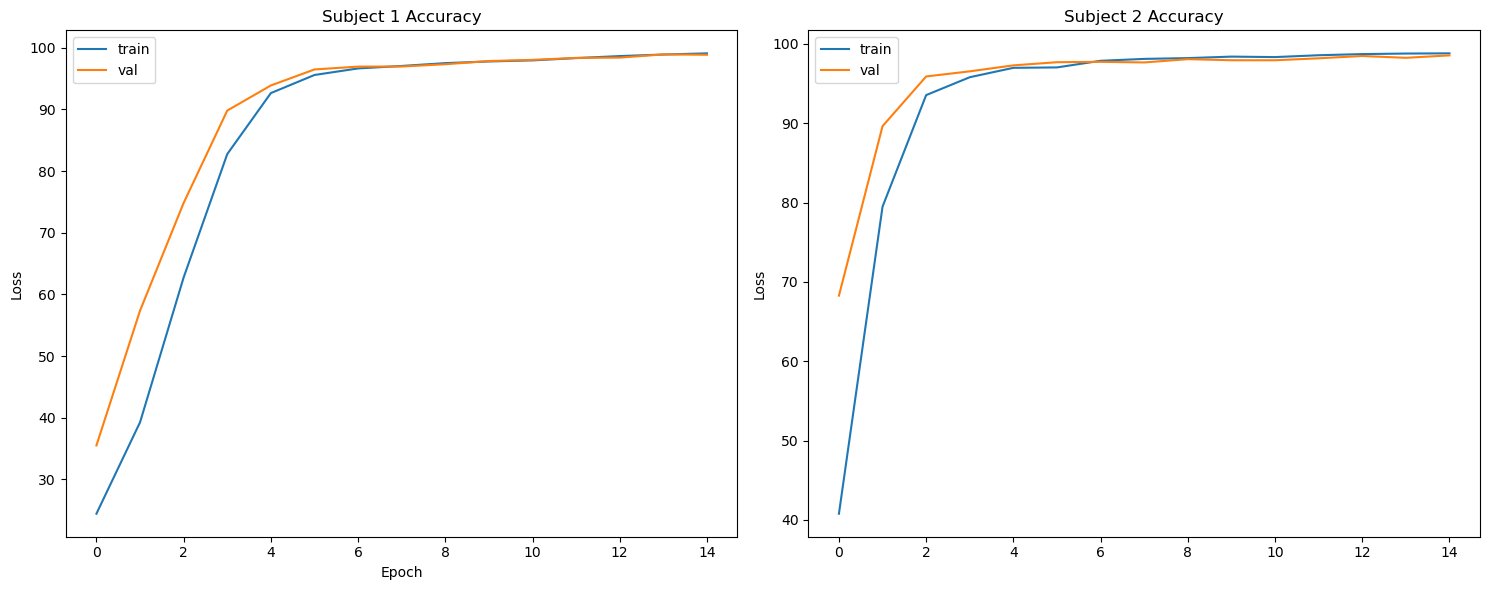

In [20]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 7: Layer=3, Hidden=32

In [46]:
hidden_size = 32
num_layers = 3

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 34.42%, Validation Accuracy: 55.48%, Epoch Time: 9313.6220ms
Epoch [2/15], Train Accuracy: 58.23%, Validation Accuracy: 65.28%, Epoch Time: 9119.8070ms
Epoch [3/15], Train Accuracy: 73.03%, Validation Accuracy: 77.77%, Epoch Time: 9081.9240ms
Epoch [4/15], Train Accuracy: 79.57%, Validation Accuracy: 82.15%, Epoch Time: 9126.9691ms
Epoch [5/15], Train Accuracy: 86.14%, Validation Accuracy: 88.62%, Epoch Time: 9048.0952ms
Epoch [6/15], Train Accuracy: 91.84%, Validation Accuracy: 92.15%, Epoch Time: 9095.8049ms
Epoch [7/15], Train Accuracy: 93.63%, Validation Accuracy: 93.73%, Epoch Time: 9000.8609ms
Epoch [8/15], Train Accuracy: 94.40%, Validation Accuracy: 94.88%, Epoch Time: 9135.4690ms
Epoch [9/15], Train Accuracy: 95.11%, Validation Accuracy: 95.51%, Epoch Time: 9572.1099ms
Epoch [10/15], Train Accuracy: 95.41%, Validation Accuracy: 95.81%, Epoch Time: 9043.1890ms
Epoch [11/15], Train Accuracy: 96.00%, Validation Accuracy: 95.93%,

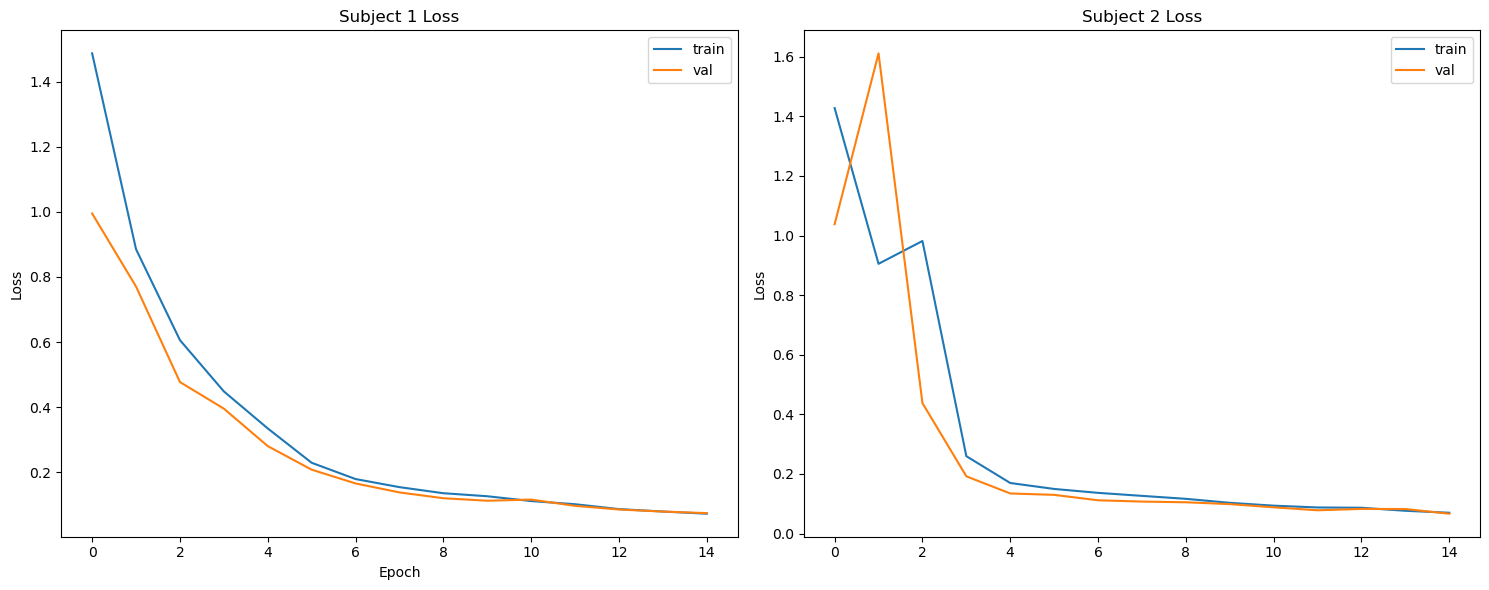

In [47]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

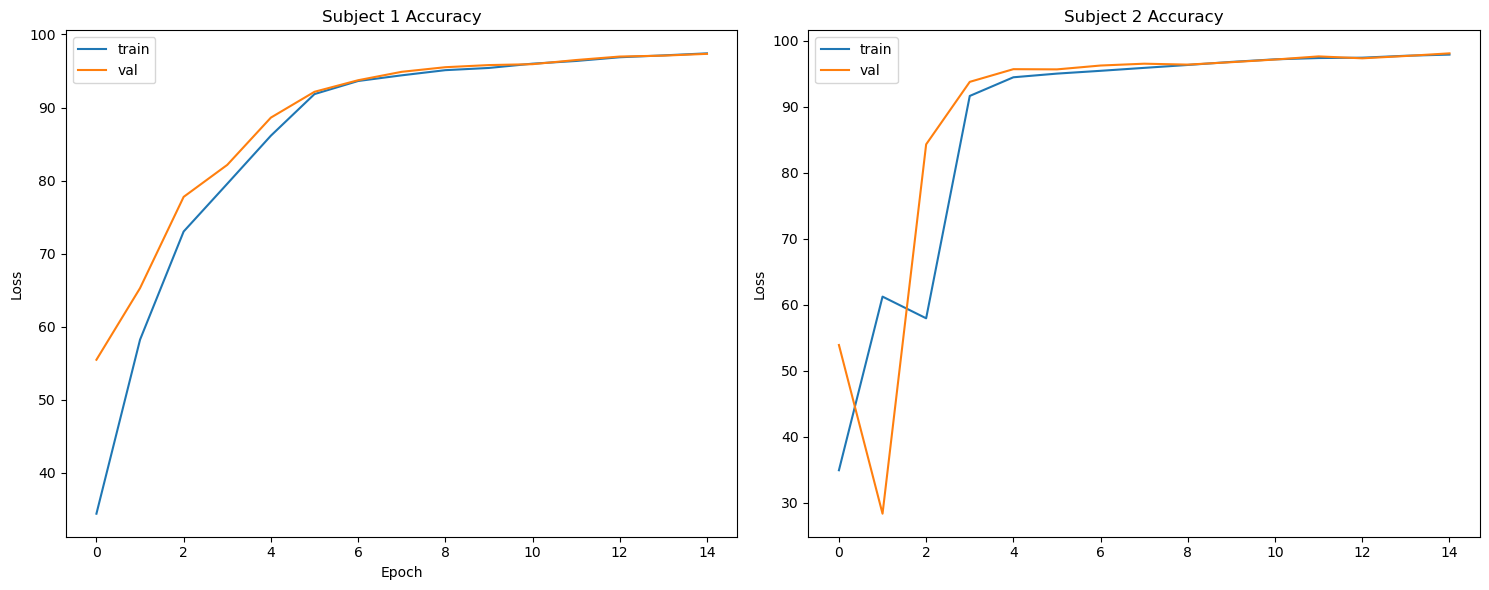

In [48]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 8: Layer=3, Hidden=64

In [49]:
hidden_size = 64
num_layers = 3

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 22.92%, Validation Accuracy: 29.40%, Epoch Time: 10195.9453ms
Epoch [2/15], Train Accuracy: 29.32%, Validation Accuracy: 37.70%, Epoch Time: 9769.5999ms
Epoch [3/15], Train Accuracy: 28.78%, Validation Accuracy: 34.04%, Epoch Time: 9847.3783ms
Epoch [4/15], Train Accuracy: 42.26%, Validation Accuracy: 50.98%, Epoch Time: 9808.0709ms
Epoch [5/15], Train Accuracy: 51.67%, Validation Accuracy: 51.81%, Epoch Time: 9879.5328ms
Epoch [6/15], Train Accuracy: 59.11%, Validation Accuracy: 65.42%, Epoch Time: 9866.5469ms
Epoch [7/15], Train Accuracy: 68.49%, Validation Accuracy: 72.17%, Epoch Time: 9898.1352ms
Epoch [8/15], Train Accuracy: 74.26%, Validation Accuracy: 78.65%, Epoch Time: 9912.0147ms
Epoch [9/15], Train Accuracy: 81.52%, Validation Accuracy: 84.61%, Epoch Time: 9803.5970ms
Epoch [10/15], Train Accuracy: 84.43%, Validation Accuracy: 85.79%, Epoch Time: 9868.7861ms
Epoch [11/15], Train Accuracy: 86.28%, Validation Accuracy: 87.70%

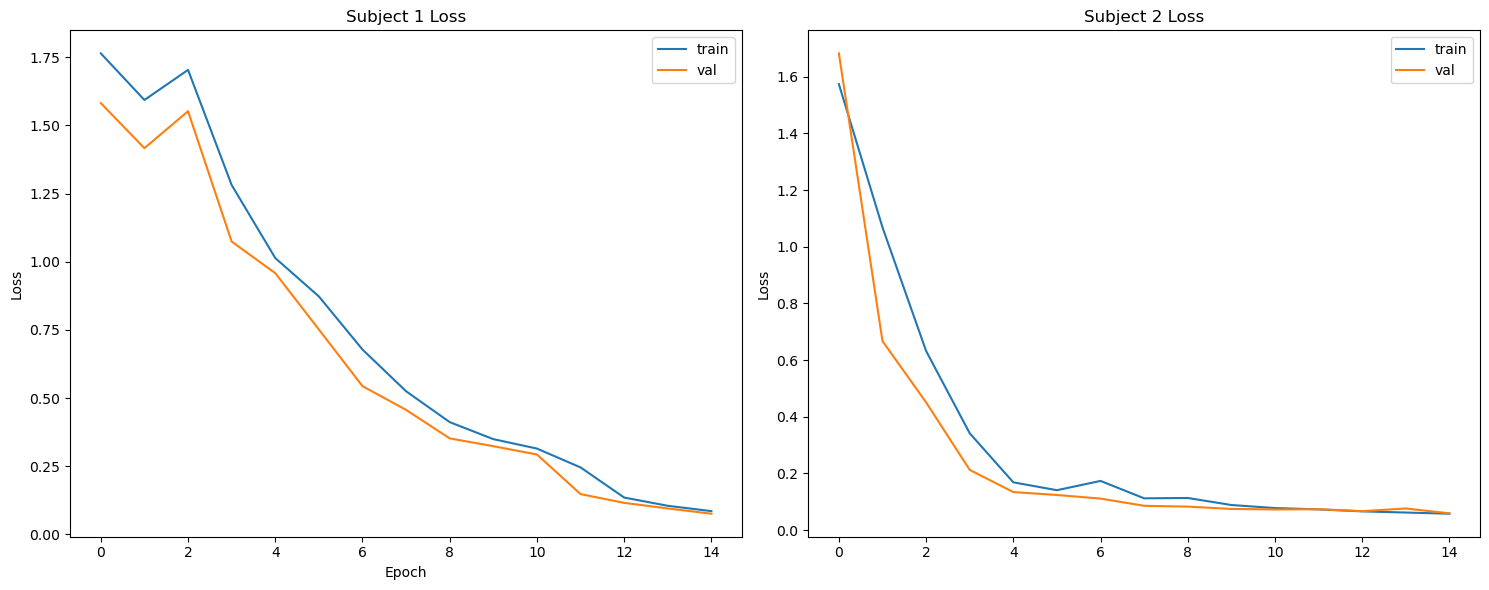

In [50]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

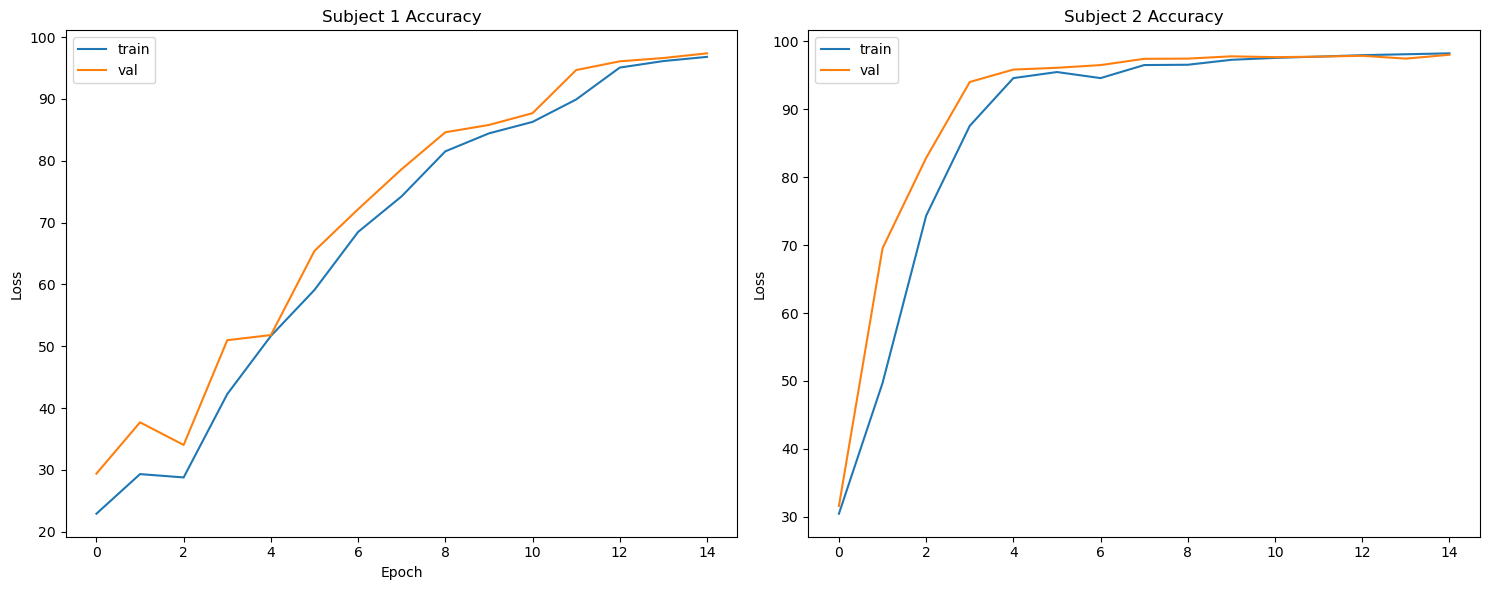

In [51]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 9: Layer=3, Hidden=128

In [52]:
hidden_size = 128
num_layers = 3

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 21.78%, Validation Accuracy: 29.83%, Epoch Time: 11181.1359ms
Epoch [2/15], Train Accuracy: 41.66%, Validation Accuracy: 56.34%, Epoch Time: 11164.6261ms
Epoch [3/15], Train Accuracy: 55.99%, Validation Accuracy: 58.85%, Epoch Time: 11235.0190ms
Epoch [4/15], Train Accuracy: 66.89%, Validation Accuracy: 76.85%, Epoch Time: 11176.8751ms
Epoch [5/15], Train Accuracy: 84.85%, Validation Accuracy: 89.65%, Epoch Time: 11227.6640ms
Epoch [6/15], Train Accuracy: 91.52%, Validation Accuracy: 92.35%, Epoch Time: 11369.9391ms
Epoch [7/15], Train Accuracy: 93.05%, Validation Accuracy: 93.29%, Epoch Time: 11489.0430ms
Epoch [8/15], Train Accuracy: 93.88%, Validation Accuracy: 94.38%, Epoch Time: 11521.6513ms
Epoch [9/15], Train Accuracy: 94.55%, Validation Accuracy: 94.85%, Epoch Time: 11433.0068ms
Epoch [10/15], Train Accuracy: 95.22%, Validation Accuracy: 95.56%, Epoch Time: 11238.6441ms
Epoch [11/15], Train Accuracy: 96.04%, Validation Accurac

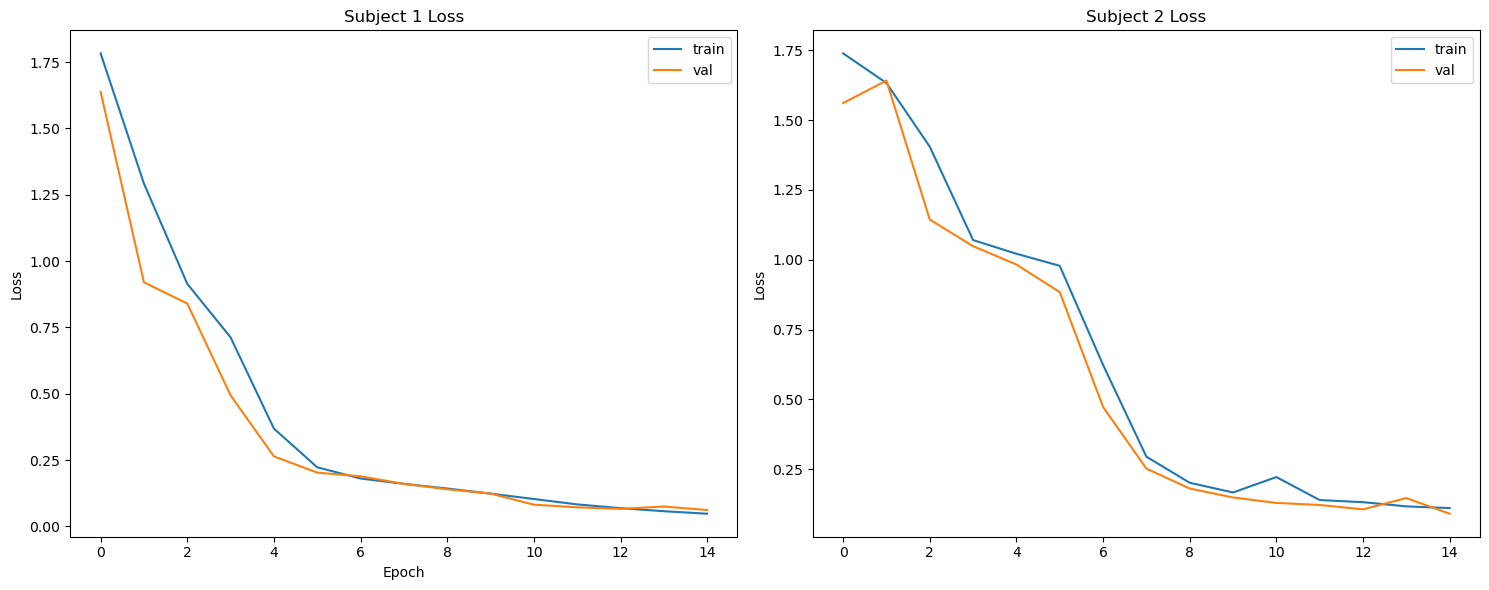

In [53]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

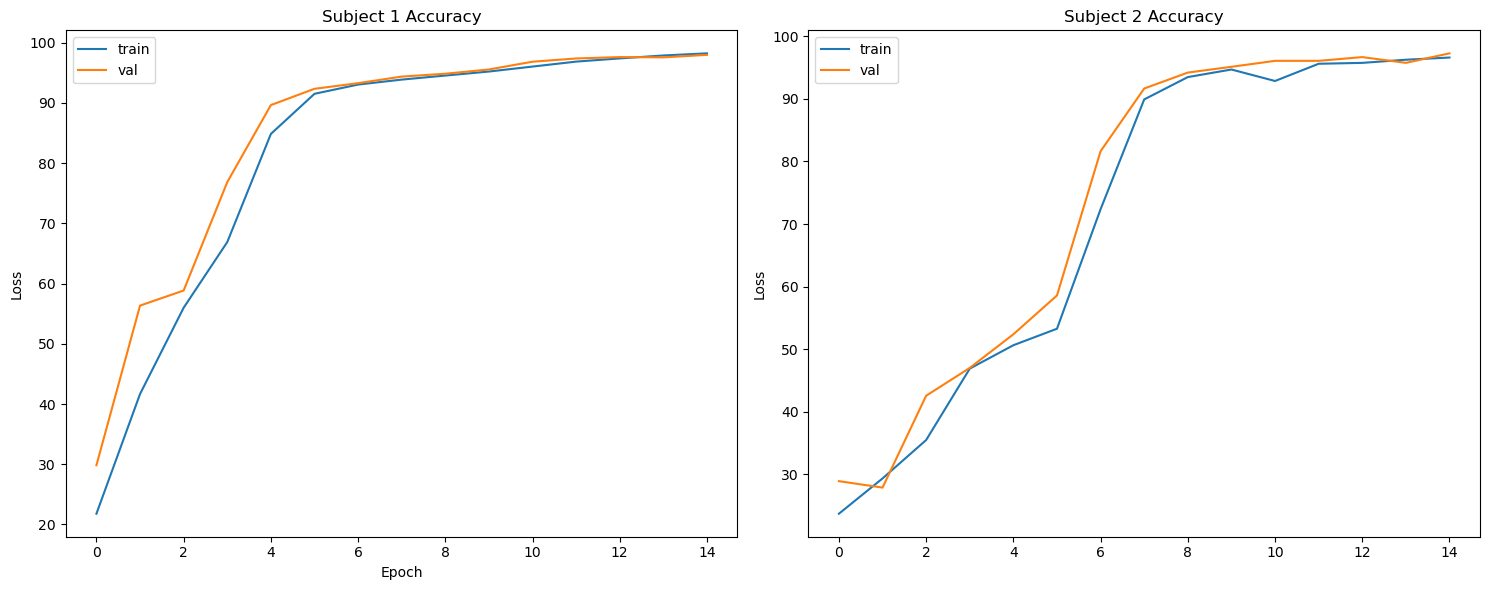

In [54]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 10: Layer=2, Hidden=64

In [56]:
hidden_size = 64
num_layers = 2

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 25.69%, Validation Accuracy: 21.81%, Epoch Time: 8584.2471ms
Epoch [2/15], Train Accuracy: 25.50%, Validation Accuracy: 24.78%, Epoch Time: 8754.8048ms
Epoch [3/15], Train Accuracy: 29.15%, Validation Accuracy: 34.67%, Epoch Time: 8599.1437ms
Epoch [4/15], Train Accuracy: 31.87%, Validation Accuracy: 44.84%, Epoch Time: 8797.0412ms
Epoch [5/15], Train Accuracy: 49.42%, Validation Accuracy: 54.27%, Epoch Time: 8848.9280ms
Epoch [6/15], Train Accuracy: 60.97%, Validation Accuracy: 73.13%, Epoch Time: 8744.3149ms
Epoch [7/15], Train Accuracy: 70.98%, Validation Accuracy: 74.70%, Epoch Time: 8548.8260ms
Epoch [8/15], Train Accuracy: 77.05%, Validation Accuracy: 81.43%, Epoch Time: 8770.9372ms
Epoch [9/15], Train Accuracy: 84.69%, Validation Accuracy: 89.20%, Epoch Time: 8702.2521ms
Epoch [10/15], Train Accuracy: 92.30%, Validation Accuracy: 94.10%, Epoch Time: 8775.2371ms
Epoch [11/15], Train Accuracy: 94.65%, Validation Accuracy: 95.85%,

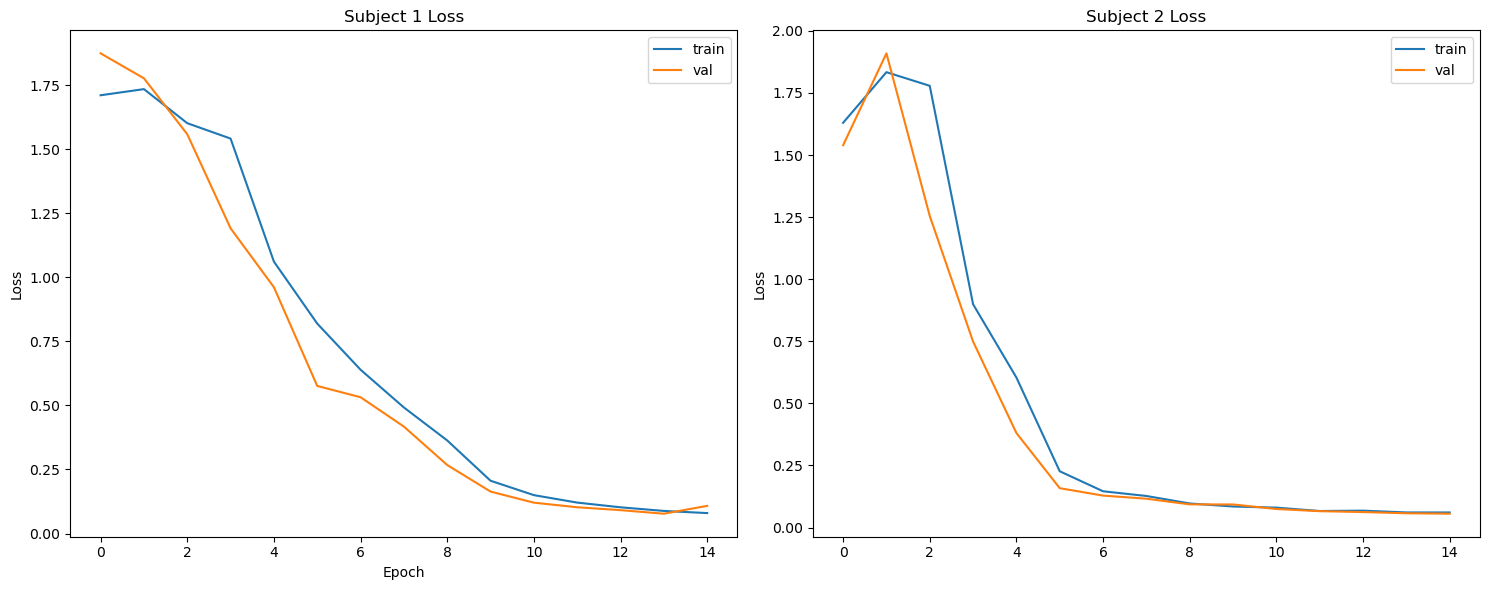

In [57]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

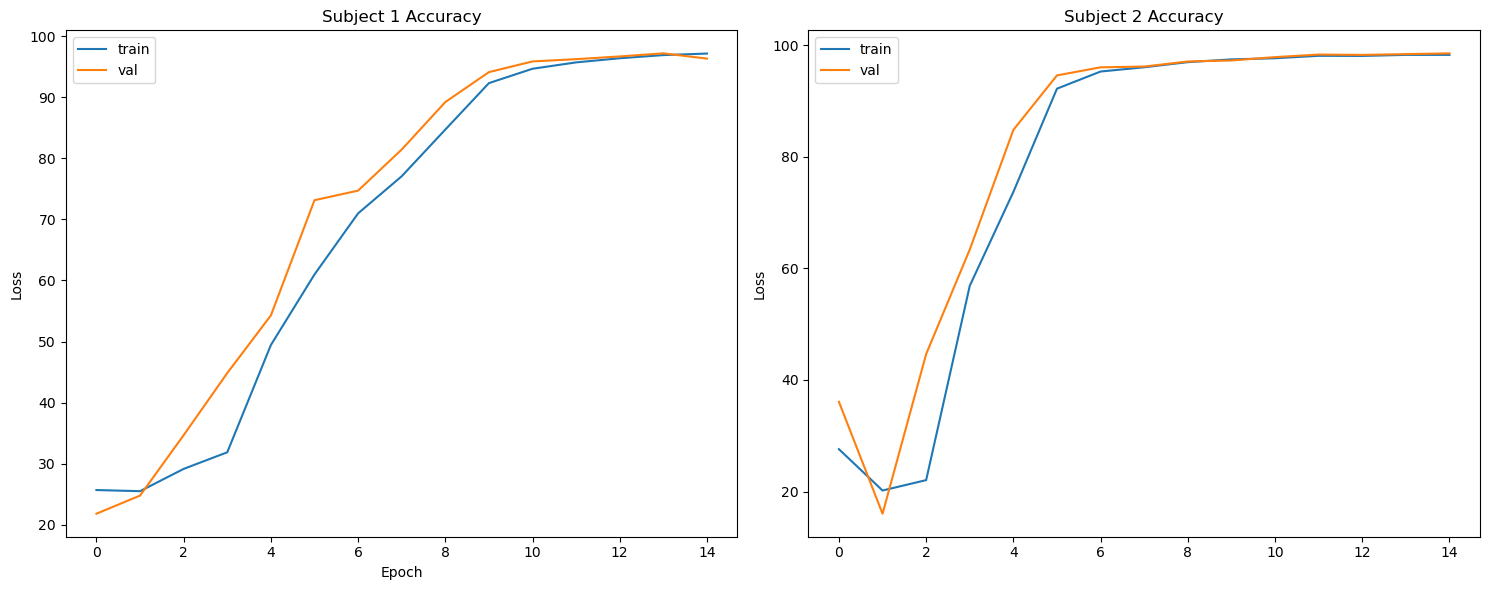

In [58]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 11: Layer=2, Hidden=32

In [59]:
hidden_size = 32
num_layers = 2

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 24.69%, Validation Accuracy: 27.17%, Epoch Time: 9652.7231ms
Epoch [2/15], Train Accuracy: 33.37%, Validation Accuracy: 43.04%, Epoch Time: 9663.2221ms
Epoch [3/15], Train Accuracy: 39.36%, Validation Accuracy: 42.96%, Epoch Time: 9581.6293ms
Epoch [4/15], Train Accuracy: 47.21%, Validation Accuracy: 51.08%, Epoch Time: 9667.1469ms
Epoch [5/15], Train Accuracy: 60.85%, Validation Accuracy: 68.56%, Epoch Time: 9608.4261ms
Epoch [6/15], Train Accuracy: 69.83%, Validation Accuracy: 73.81%, Epoch Time: 9838.1870ms
Epoch [7/15], Train Accuracy: 74.44%, Validation Accuracy: 78.03%, Epoch Time: 9638.0150ms
Epoch [8/15], Train Accuracy: 78.16%, Validation Accuracy: 79.29%, Epoch Time: 9610.1489ms
Epoch [9/15], Train Accuracy: 86.27%, Validation Accuracy: 88.80%, Epoch Time: 9453.8219ms
Epoch [10/15], Train Accuracy: 90.16%, Validation Accuracy: 90.35%, Epoch Time: 9516.0458ms
Epoch [11/15], Train Accuracy: 91.22%, Validation Accuracy: 91.29%,

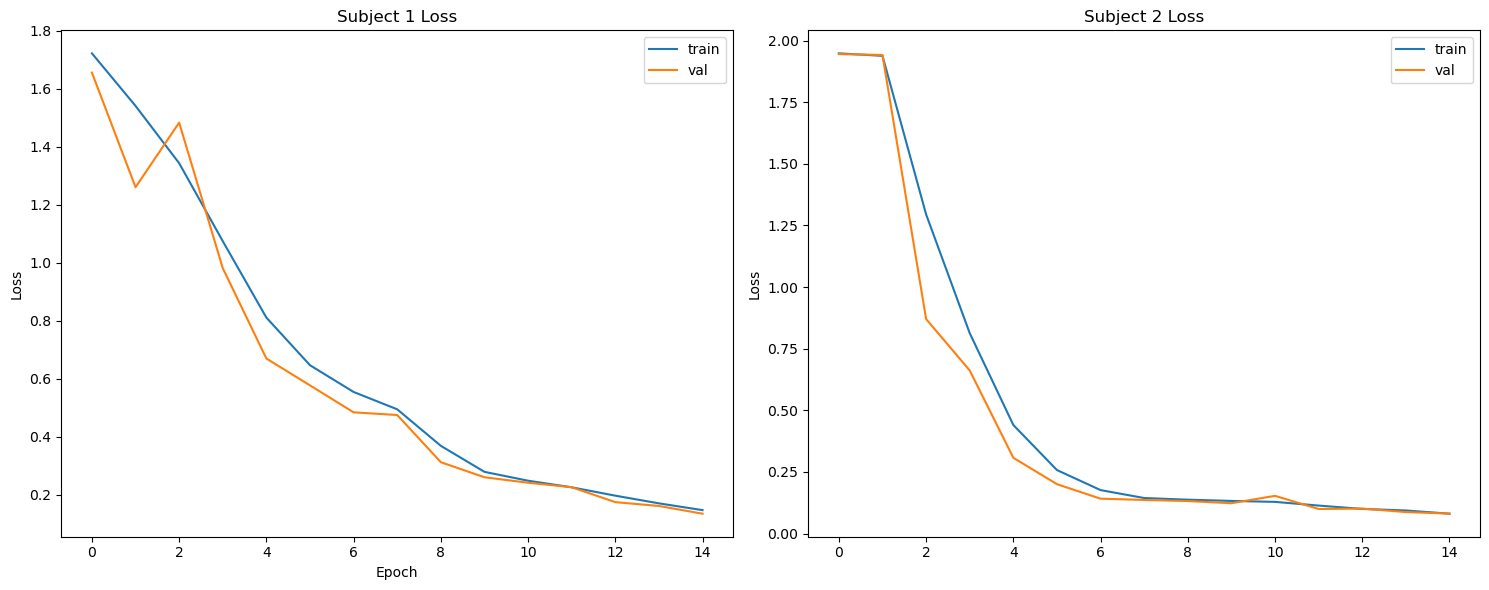

In [60]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

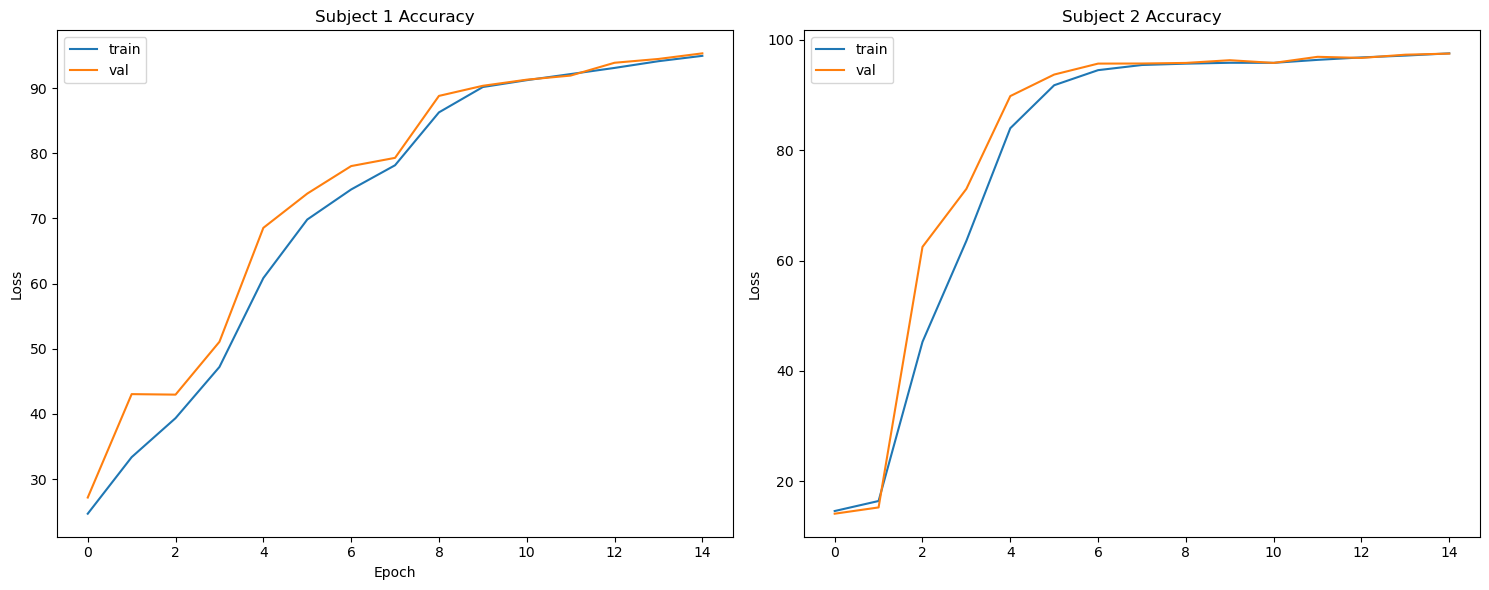

In [61]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + SGD

In [21]:
hidden_size = 128
num_layers = 2

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=.9)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=.9)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 14.30%, Validation Accuracy: 14.13%, Epoch Time: 10840.7178ms
Epoch [2/15], Train Accuracy: 14.20%, Validation Accuracy: 11.69%, Epoch Time: 10613.4489ms
Epoch [3/15], Train Accuracy: 14.09%, Validation Accuracy: 14.35%, Epoch Time: 10835.2652ms
Epoch [4/15], Train Accuracy: 14.00%, Validation Accuracy: 14.19%, Epoch Time: 10614.5422ms
Epoch [5/15], Train Accuracy: 14.01%, Validation Accuracy: 14.18%, Epoch Time: 10251.9939ms
Epoch [6/15], Train Accuracy: 14.01%, Validation Accuracy: 14.18%, Epoch Time: 11043.2529ms
Epoch [7/15], Train Accuracy: 14.01%, Validation Accuracy: 14.18%, Epoch Time: 10911.0229ms
Epoch [8/15], Train Accuracy: 14.01%, Validation Accuracy: 14.18%, Epoch Time: 10482.7862ms
Epoch [9/15], Train Accuracy: 14.01%, Validation Accuracy: 14.18%, Epoch Time: 10529.2079ms
Epoch [10/15], Train Accuracy: 14.01%, Validation Accuracy: 14.19%, Epoch Time: 10599.2732ms
Epoch [11/15], Train Accuracy: 14.01%, Validation Accurac

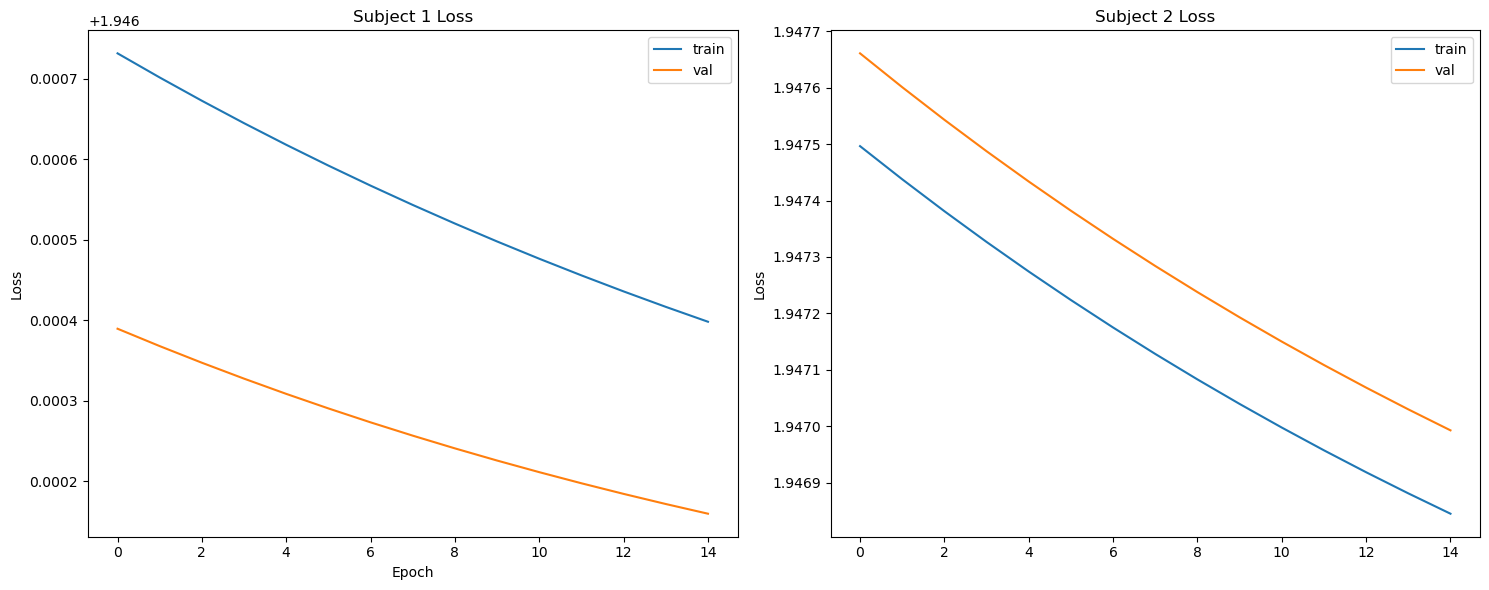

In [81]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

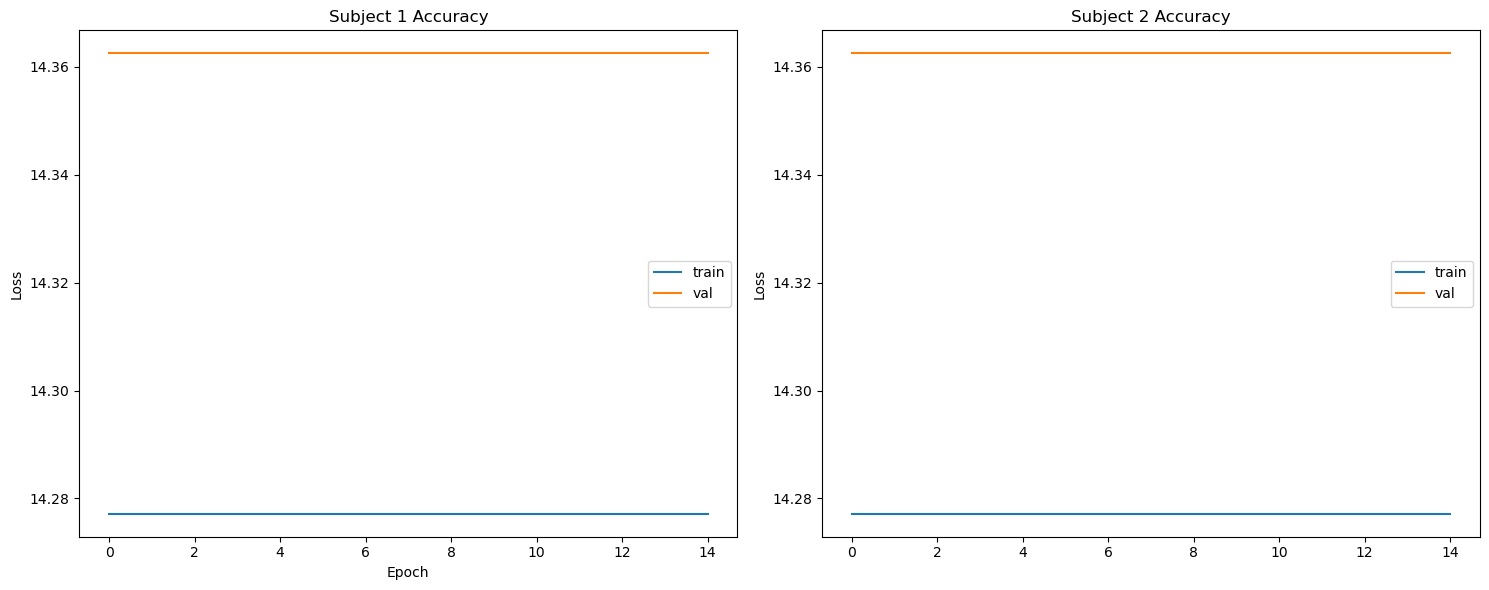

In [82]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.1

In [23]:
hidden_size = 128
num_layers = 2

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.1)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.1)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 14.11%, Validation Accuracy: 14.13%, Epoch Time: 8589.1752ms
Epoch [2/15], Train Accuracy: 13.92%, Validation Accuracy: 14.13%, Epoch Time: 8651.0551ms
Epoch [3/15], Train Accuracy: 13.91%, Validation Accuracy: 14.13%, Epoch Time: 8669.0230ms
Epoch [4/15], Train Accuracy: 13.91%, Validation Accuracy: 14.13%, Epoch Time: 8638.5319ms
Epoch [5/15], Train Accuracy: 13.92%, Validation Accuracy: 14.13%, Epoch Time: 8630.4400ms
Epoch [6/15], Train Accuracy: 13.91%, Validation Accuracy: 14.13%, Epoch Time: 8599.0069ms
Epoch [7/15], Train Accuracy: 13.91%, Validation Accuracy: 14.13%, Epoch Time: 8607.1899ms
Epoch [8/15], Train Accuracy: 13.91%, Validation Accuracy: 14.13%, Epoch Time: 9049.7680ms
Epoch [9/15], Train Accuracy: 13.91%, Validation Accuracy: 14.13%, Epoch Time: 9048.1009ms
Epoch [10/15], Train Accuracy: 13.91%, Validation Accuracy: 14.13%, Epoch Time: 9123.1492ms
Epoch [11/15], Train Accuracy: 13.91%, Validation Accuracy: 14.13%,

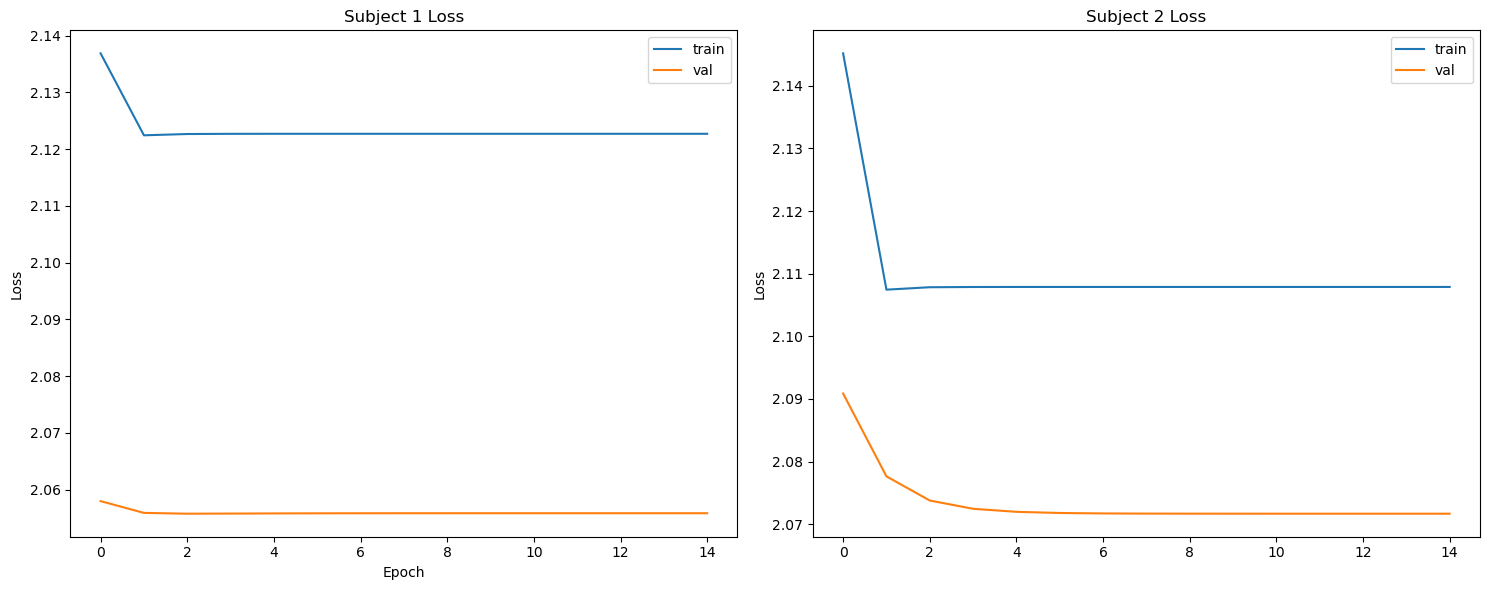

In [24]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

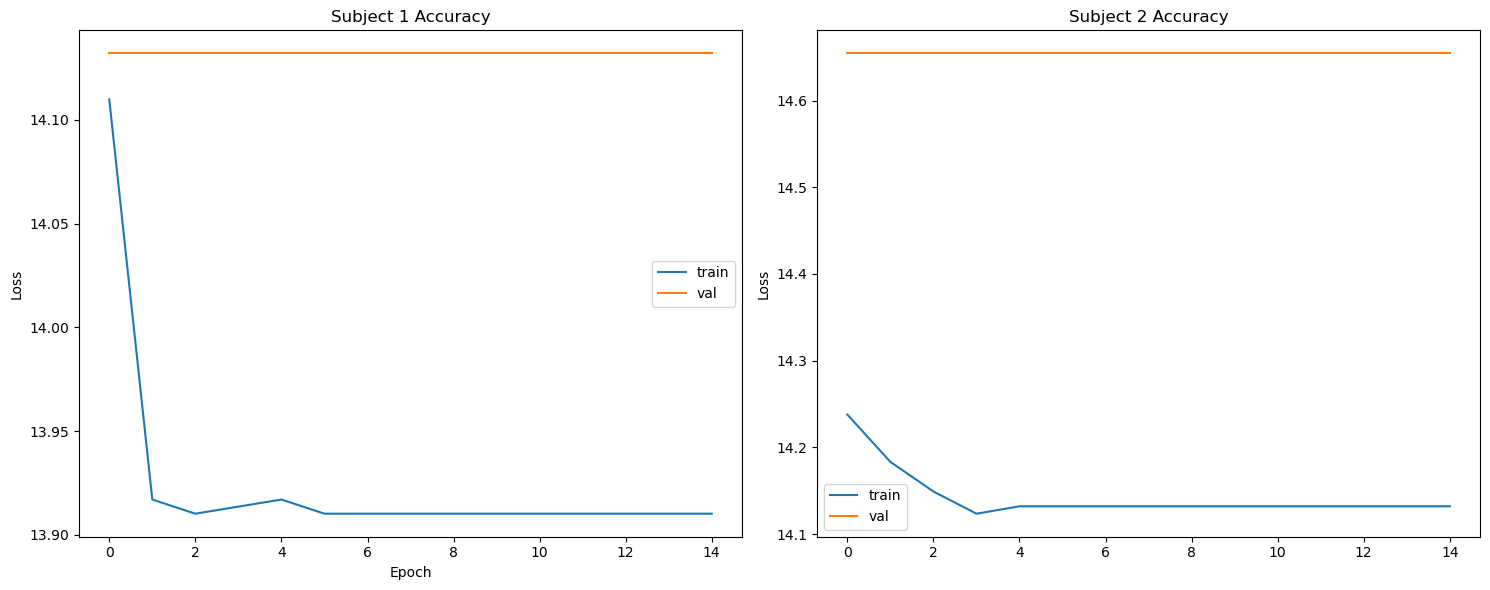

In [25]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01

In [26]:
hidden_size = 128
num_layers = 2

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 75.10%, Validation Accuracy: 95.35%, Epoch Time: 9908.1800ms
Epoch [2/15], Train Accuracy: 96.81%, Validation Accuracy: 97.76%, Epoch Time: 9047.4191ms
Epoch [3/15], Train Accuracy: 97.85%, Validation Accuracy: 98.76%, Epoch Time: 9209.6419ms
Epoch [4/15], Train Accuracy: 98.23%, Validation Accuracy: 98.66%, Epoch Time: 9026.5281ms
Epoch [5/15], Train Accuracy: 98.83%, Validation Accuracy: 99.05%, Epoch Time: 9102.0331ms
Epoch [6/15], Train Accuracy: 99.01%, Validation Accuracy: 99.23%, Epoch Time: 9181.0391ms
Epoch [7/15], Train Accuracy: 99.20%, Validation Accuracy: 99.08%, Epoch Time: 9039.8951ms
Epoch [8/15], Train Accuracy: 99.30%, Validation Accuracy: 99.28%, Epoch Time: 9800.6577ms
Epoch [9/15], Train Accuracy: 99.31%, Validation Accuracy: 99.28%, Epoch Time: 10839.4480ms
Epoch [10/15], Train Accuracy: 99.51%, Validation Accuracy: 99.02%, Epoch Time: 10811.1072ms
Epoch [11/15], Train Accuracy: 99.47%, Validation Accuracy: 98.33

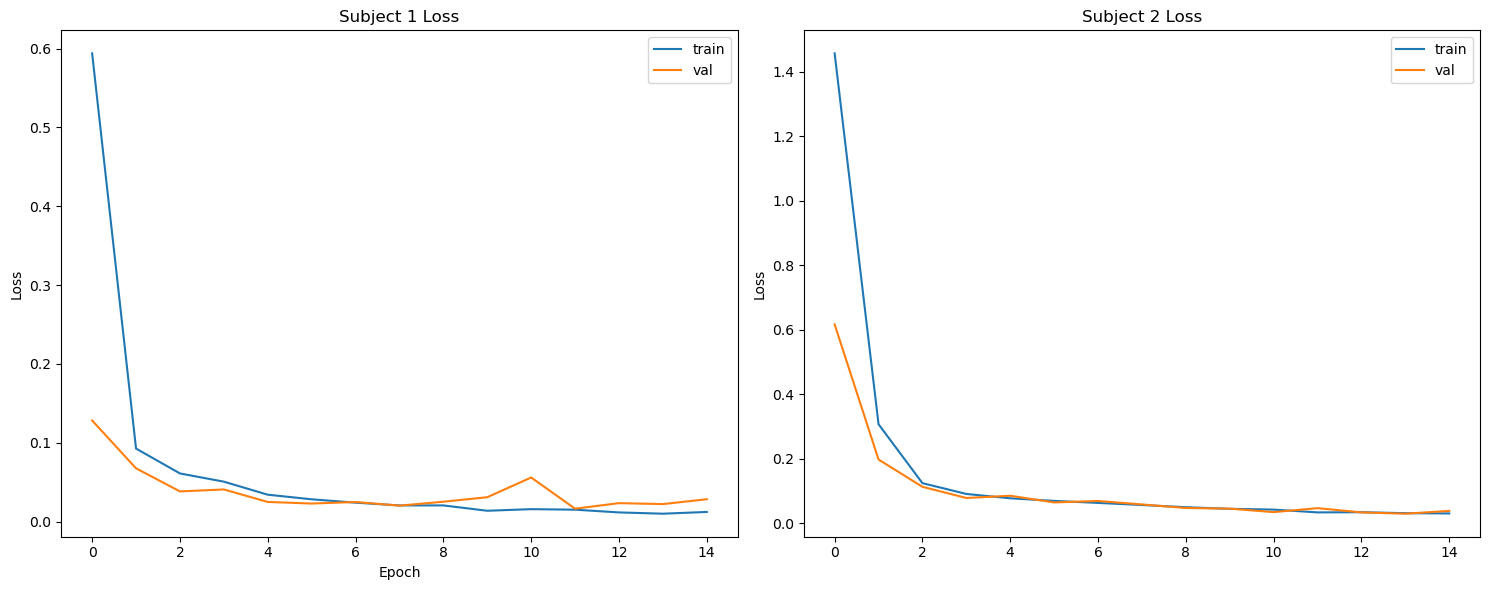

In [27]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

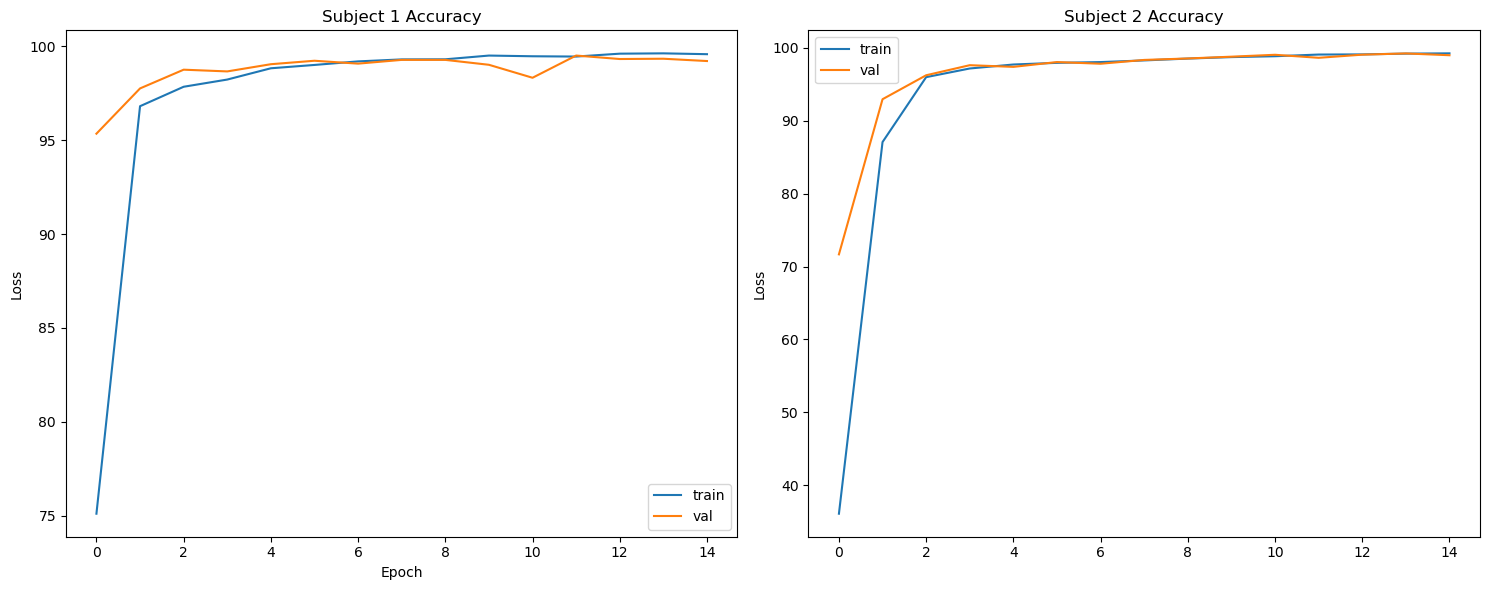

In [28]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=32

In [29]:
hidden_size = 128
num_layers = 2
batch_size = 32

print('Training on Subject 1')
print('=====================')
model1 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, 
                                                                                   optimizer1, batch_size=batch_size)

print('Training on Subject 2')
print('=====================')
model2 = LSTM(hidden_size=hidden_size, num_layers=num_layers)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, 
                                                                                   optimizer2, batch_size=batch_size)

Training on Subject 1
Epoch [1/15], Train Accuracy: 41.88%, Validation Accuracy: 71.86%, Epoch Time: 18759.1822ms
Epoch [2/15], Train Accuracy: 87.24%, Validation Accuracy: 93.69%, Epoch Time: 17499.0048ms
Epoch [3/15], Train Accuracy: 95.48%, Validation Accuracy: 96.01%, Epoch Time: 17235.6701ms
Epoch [4/15], Train Accuracy: 97.13%, Validation Accuracy: 97.79%, Epoch Time: 17398.0019ms
Epoch [5/15], Train Accuracy: 97.78%, Validation Accuracy: 97.37%, Epoch Time: 17976.8460ms
Epoch [6/15], Train Accuracy: 98.19%, Validation Accuracy: 98.48%, Epoch Time: 18041.1110ms
Epoch [7/15], Train Accuracy: 98.54%, Validation Accuracy: 98.80%, Epoch Time: 17715.0421ms
Epoch [8/15], Train Accuracy: 98.64%, Validation Accuracy: 98.92%, Epoch Time: 20490.9558ms
Epoch [9/15], Train Accuracy: 98.93%, Validation Accuracy: 99.02%, Epoch Time: 20599.5030ms
Epoch [10/15], Train Accuracy: 98.99%, Validation Accuracy: 99.14%, Epoch Time: 20649.1561ms
Epoch [11/15], Train Accuracy: 99.14%, Validation Accurac

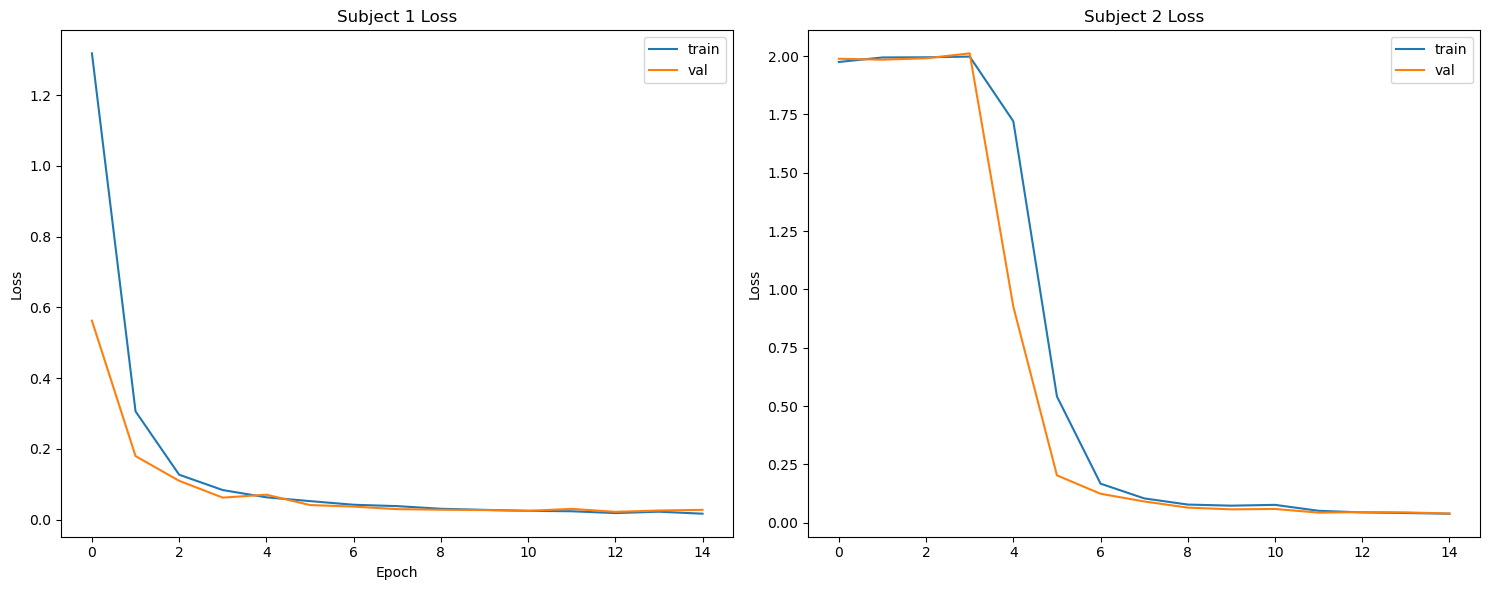

In [30]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

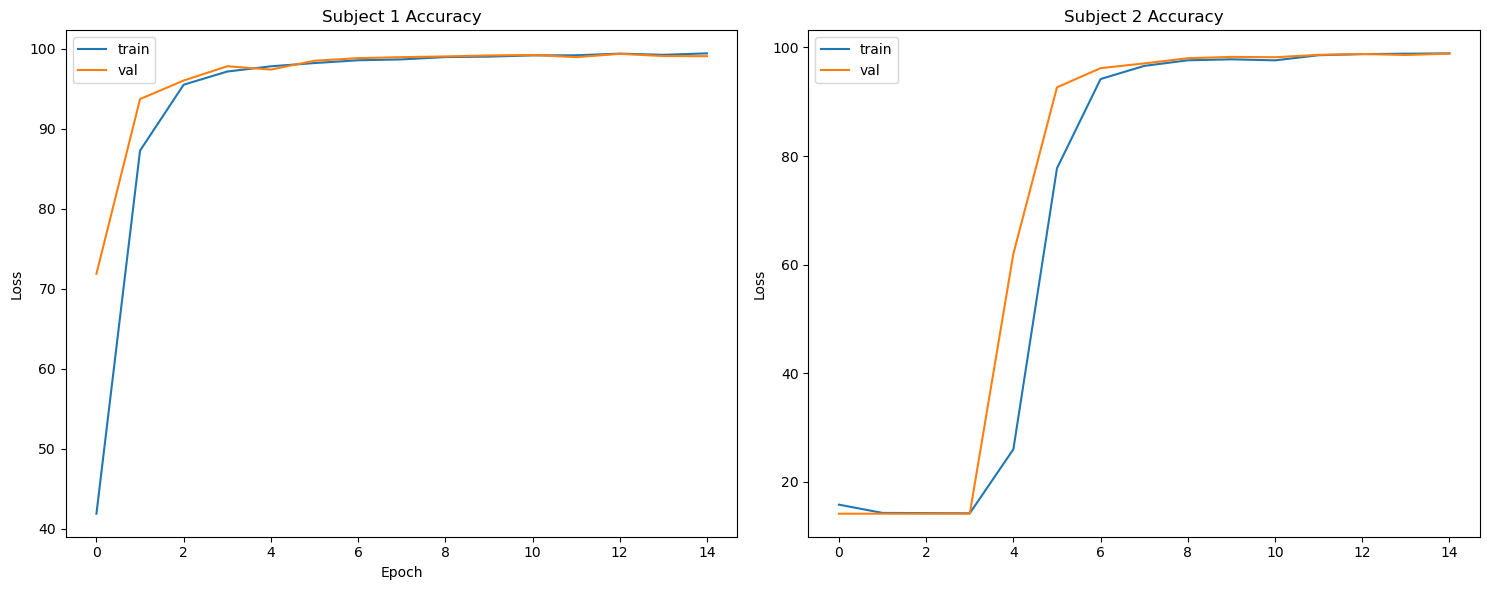

In [31]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=128

In [82]:
batch_size = 128

print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, 
                                                                                   optimizer1, batch_size=batch_size)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, 
                                                                                   optimizer2, batch_size=batch_size)

Training on Subject 1
Epoch [1/15], Train Accuracy: 26.79%, Validation Accuracy: 62.81%, Epoch Time: 6543.6571ms
Epoch [2/15], Train Accuracy: 71.71%, Validation Accuracy: 80.14%, Epoch Time: 6347.5430ms
Epoch [3/15], Train Accuracy: 86.69%, Validation Accuracy: 94.25%, Epoch Time: 6480.7982ms
Epoch [4/15], Train Accuracy: 95.40%, Validation Accuracy: 96.25%, Epoch Time: 6645.9041ms
Epoch [5/15], Train Accuracy: 96.63%, Validation Accuracy: 96.73%, Epoch Time: 5662.1470ms
Epoch [6/15], Train Accuracy: 97.28%, Validation Accuracy: 97.45%, Epoch Time: 5381.7880ms
Epoch [7/15], Train Accuracy: 97.76%, Validation Accuracy: 97.73%, Epoch Time: 5362.9940ms
Epoch [8/15], Train Accuracy: 98.12%, Validation Accuracy: 97.59%, Epoch Time: 5373.7779ms
Epoch [9/15], Train Accuracy: 98.38%, Validation Accuracy: 98.46%, Epoch Time: 5403.9288ms
Epoch [10/15], Train Accuracy: 98.65%, Validation Accuracy: 98.54%, Epoch Time: 5372.0222ms
Epoch [11/15], Train Accuracy: 98.86%, Validation Accuracy: 98.83%,

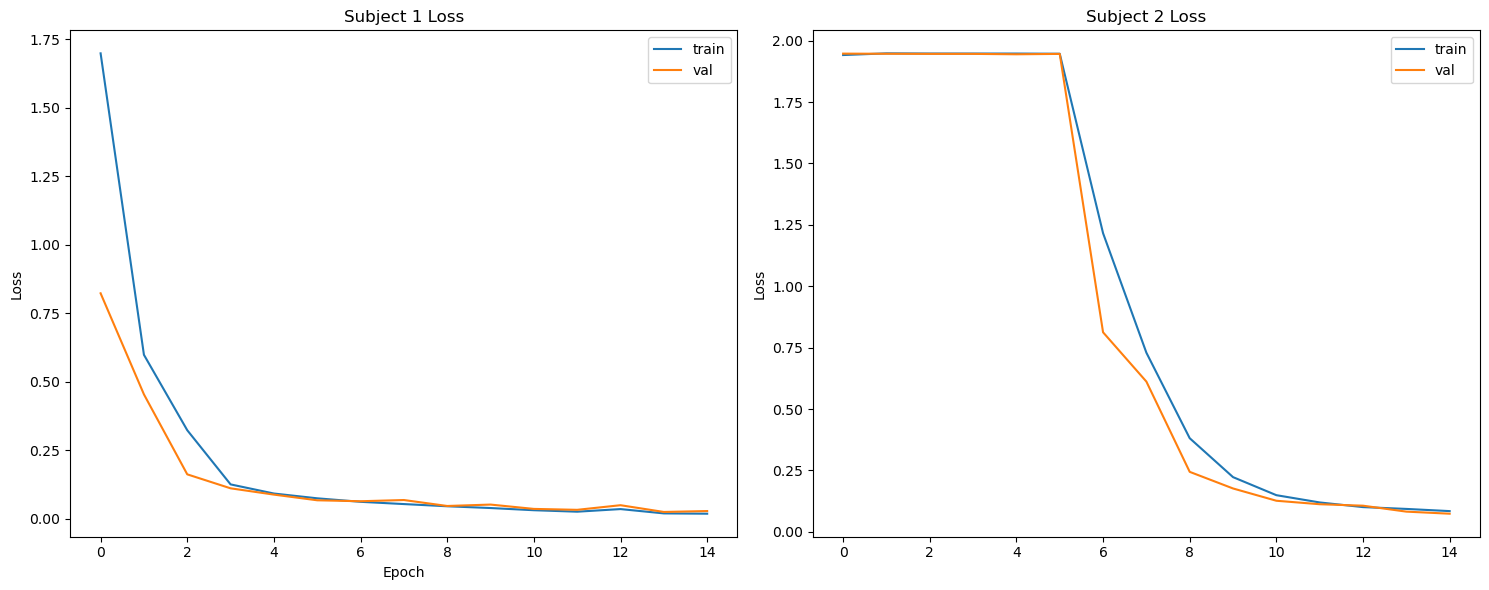

In [83]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

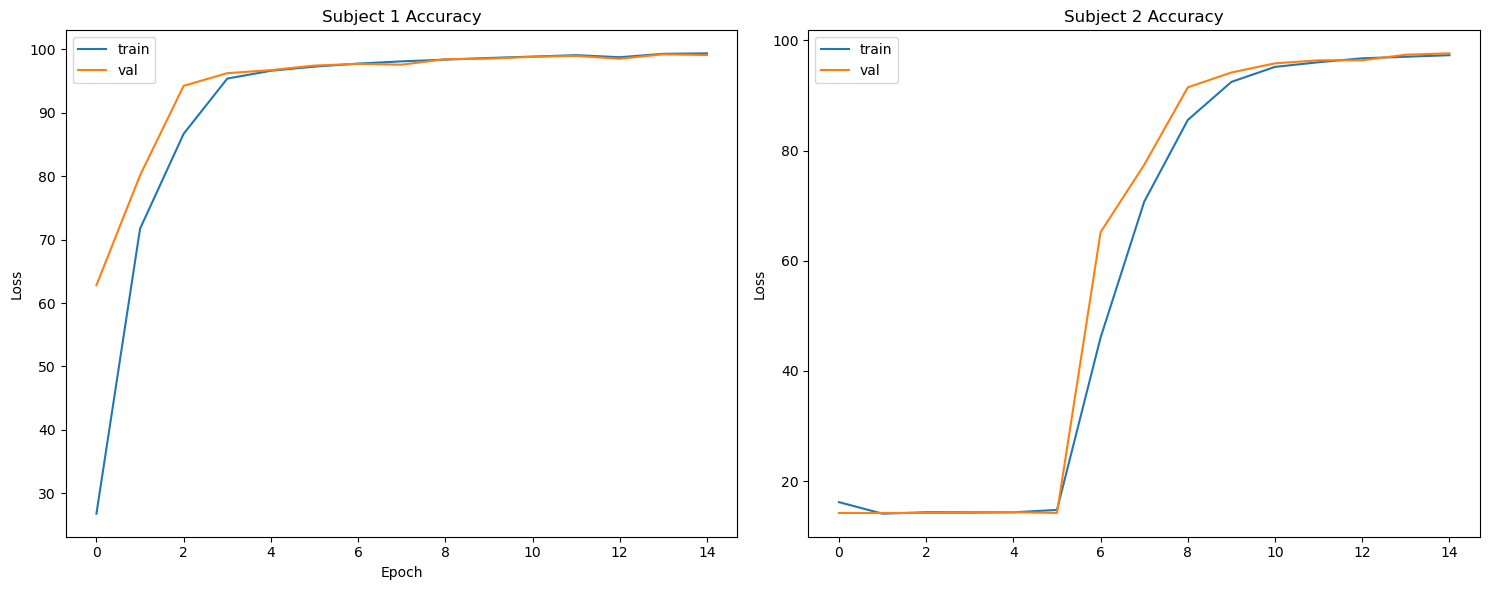

In [84]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=256

In [85]:
batch_size = 256

print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, 
                                                                                   optimizer1, batch_size=batch_size)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, 
                                                                                   optimizer2, batch_size=batch_size)

Training on Subject 1
Epoch [1/15], Train Accuracy: 38.33%, Validation Accuracy: 55.71%, Epoch Time: 4862.1399ms
Epoch [2/15], Train Accuracy: 76.39%, Validation Accuracy: 90.83%, Epoch Time: 4809.5613ms
Epoch [3/15], Train Accuracy: 93.71%, Validation Accuracy: 95.96%, Epoch Time: 4809.0491ms
Epoch [4/15], Train Accuracy: 96.87%, Validation Accuracy: 97.30%, Epoch Time: 5006.3932ms
Epoch [5/15], Train Accuracy: 97.69%, Validation Accuracy: 96.57%, Epoch Time: 4875.2389ms
Epoch [6/15], Train Accuracy: 98.08%, Validation Accuracy: 98.29%, Epoch Time: 4795.6960ms
Epoch [7/15], Train Accuracy: 98.39%, Validation Accuracy: 98.60%, Epoch Time: 4829.9751ms
Epoch [8/15], Train Accuracy: 98.90%, Validation Accuracy: 98.57%, Epoch Time: 4861.7458ms
Epoch [9/15], Train Accuracy: 98.97%, Validation Accuracy: 99.00%, Epoch Time: 4793.4768ms
Epoch [10/15], Train Accuracy: 99.12%, Validation Accuracy: 98.57%, Epoch Time: 4881.6378ms
Epoch [11/15], Train Accuracy: 99.14%, Validation Accuracy: 99.17%,

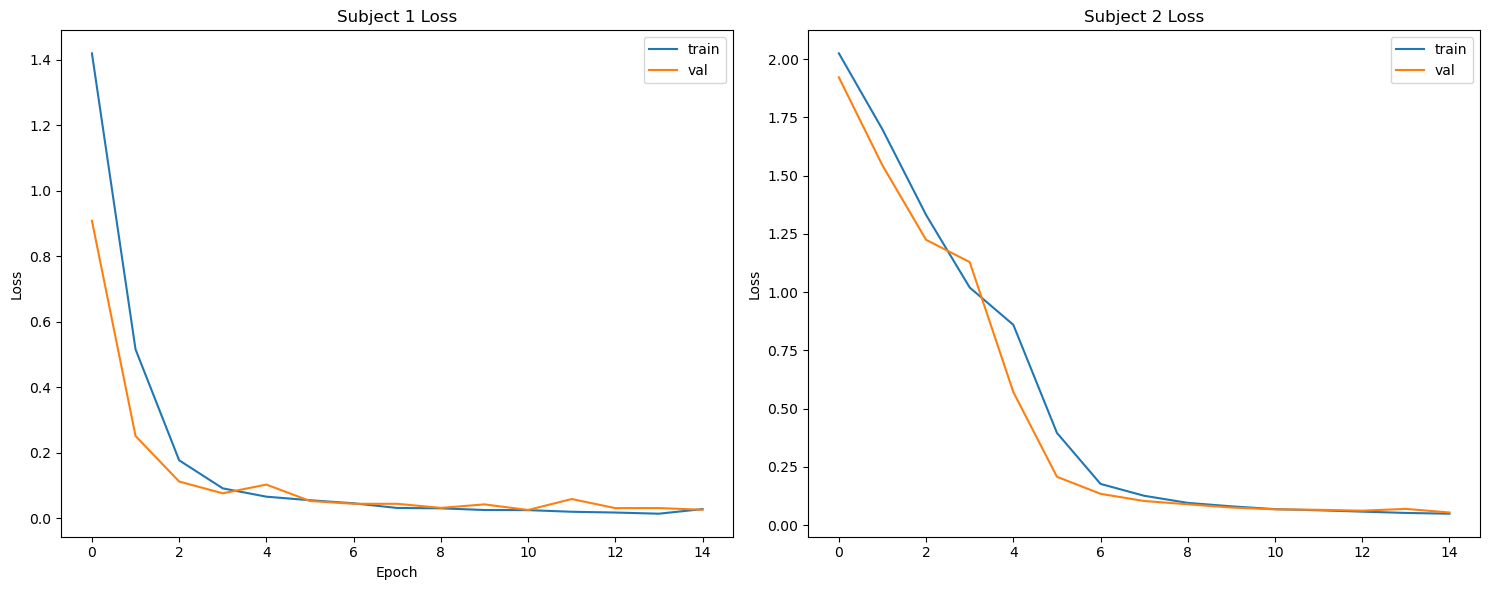

In [86]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

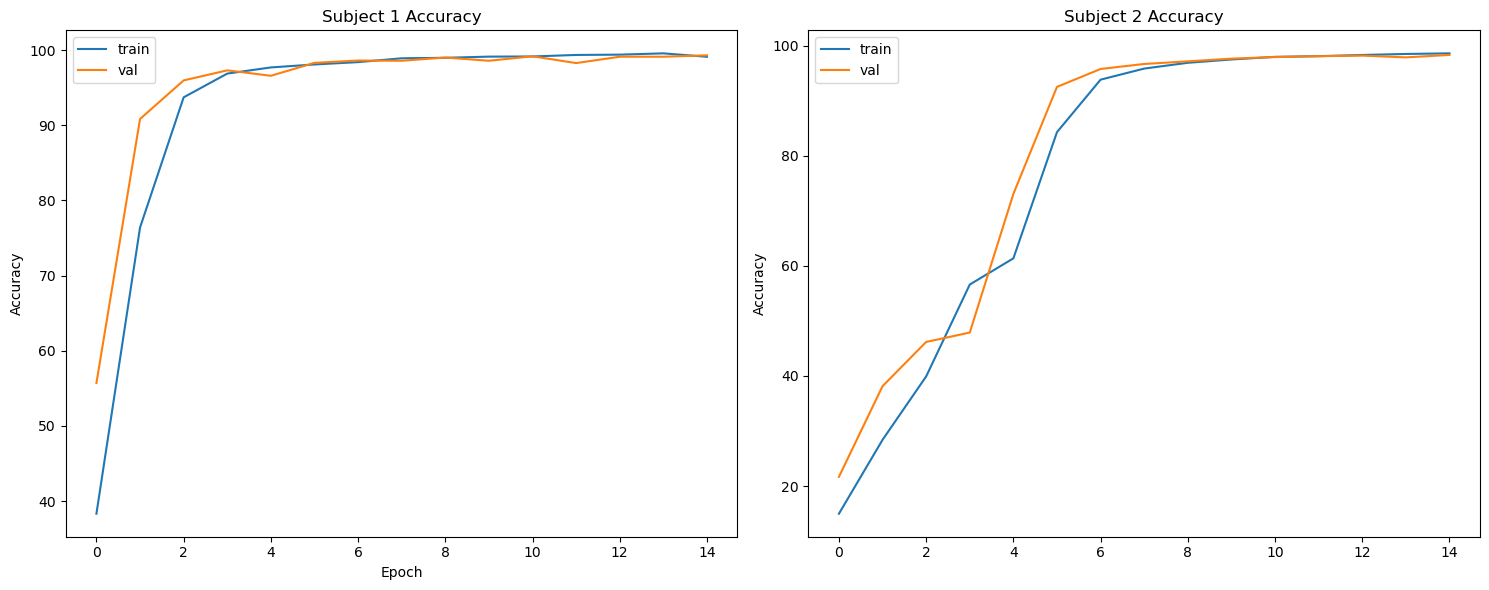

In [87]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=64, Momentum=0.95

In [90]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, betas=(.95, .999))

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, betas=(.95, .999))

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 9073.9222ms
Epoch [2/15], Train Accuracy: 14.33%, Validation Accuracy: 14.13%, Epoch Time: 9030.5958ms
Epoch [3/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 8935.5228ms
Epoch [4/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 8948.5099ms
Epoch [5/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 9986.6860ms
Epoch [6/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 10043.3998ms
Epoch [7/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 10165.0162ms
Epoch [8/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 10160.5401ms
Epoch [9/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 10248.7512ms
Epoch [10/15], Train Accuracy: 14.34%, Validation Accuracy: 14.13%, Epoch Time: 10180.3961ms
Epoch [11/15], Train Accuracy: 14.34%, Validation Accuracy: 14

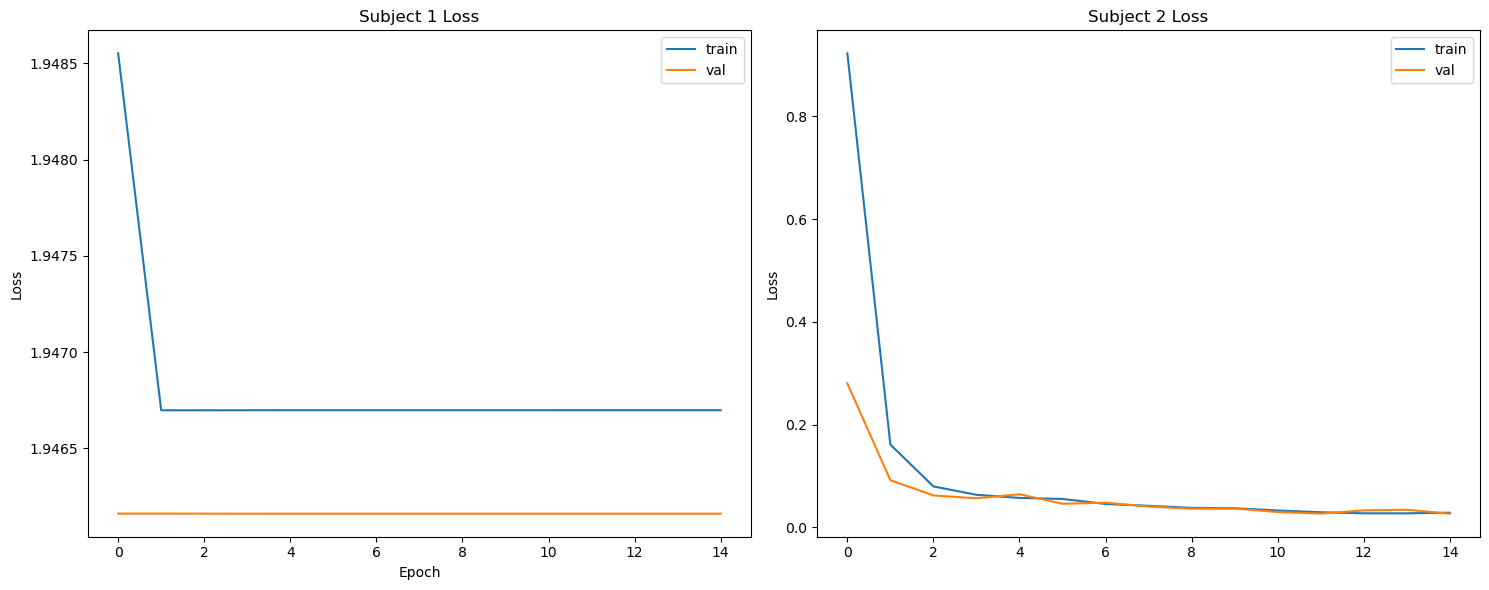

In [91]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

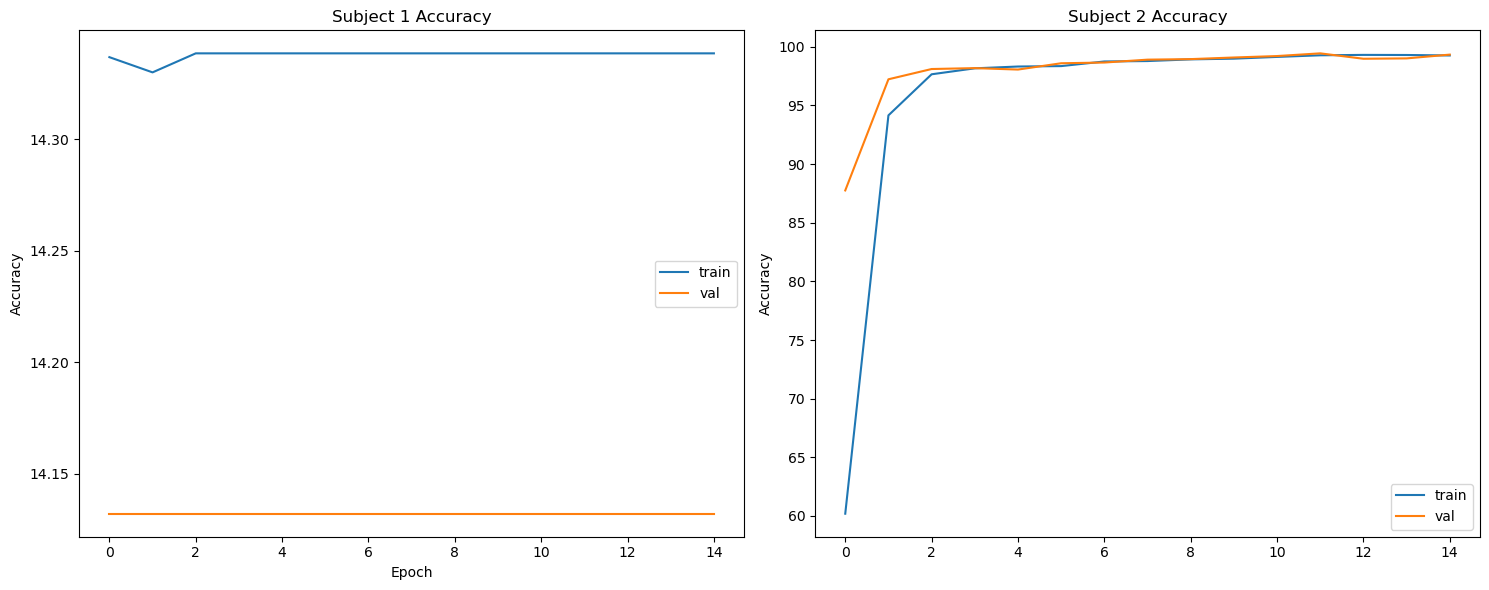

In [92]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=64, Momentum=0.80

In [93]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, betas=(.80, .999))

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, betas=(.80, .999))

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 14.38%, Validation Accuracy: 14.13%, Epoch Time: 9067.3077ms
Epoch [2/15], Train Accuracy: 14.20%, Validation Accuracy: 14.13%, Epoch Time: 8896.5909ms
Epoch [3/15], Train Accuracy: 14.21%, Validation Accuracy: 14.13%, Epoch Time: 8966.8722ms
Epoch [4/15], Train Accuracy: 14.24%, Validation Accuracy: 14.13%, Epoch Time: 9094.2950ms
Epoch [5/15], Train Accuracy: 14.25%, Validation Accuracy: 14.13%, Epoch Time: 9063.1721ms
Epoch [6/15], Train Accuracy: 14.24%, Validation Accuracy: 14.13%, Epoch Time: 9168.5872ms
Epoch [7/15], Train Accuracy: 14.24%, Validation Accuracy: 14.13%, Epoch Time: 9095.6111ms
Epoch [8/15], Train Accuracy: 14.24%, Validation Accuracy: 14.13%, Epoch Time: 9169.9750ms
Epoch [9/15], Train Accuracy: 14.24%, Validation Accuracy: 14.13%, Epoch Time: 8897.9919ms
Epoch [10/15], Train Accuracy: 15.52%, Validation Accuracy: 23.84%, Epoch Time: 9274.7300ms
Epoch [11/15], Train Accuracy: 29.83%, Validation Accuracy: 29.65%,

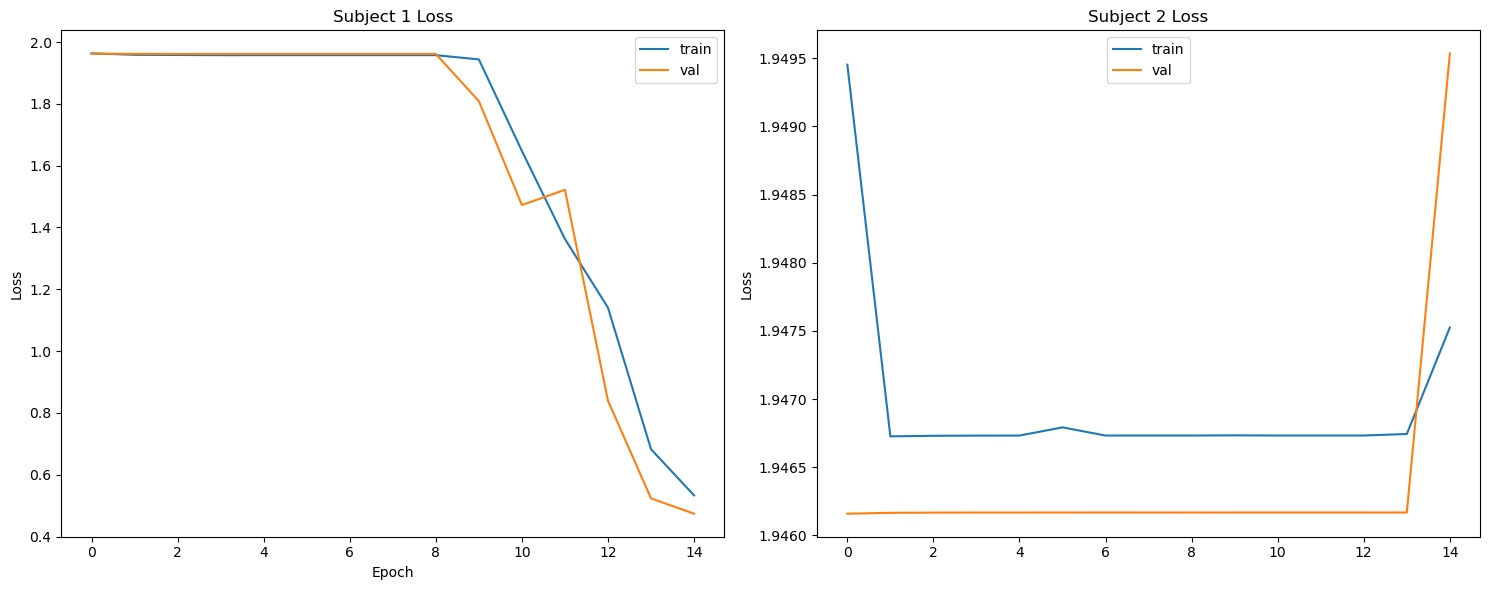

In [94]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

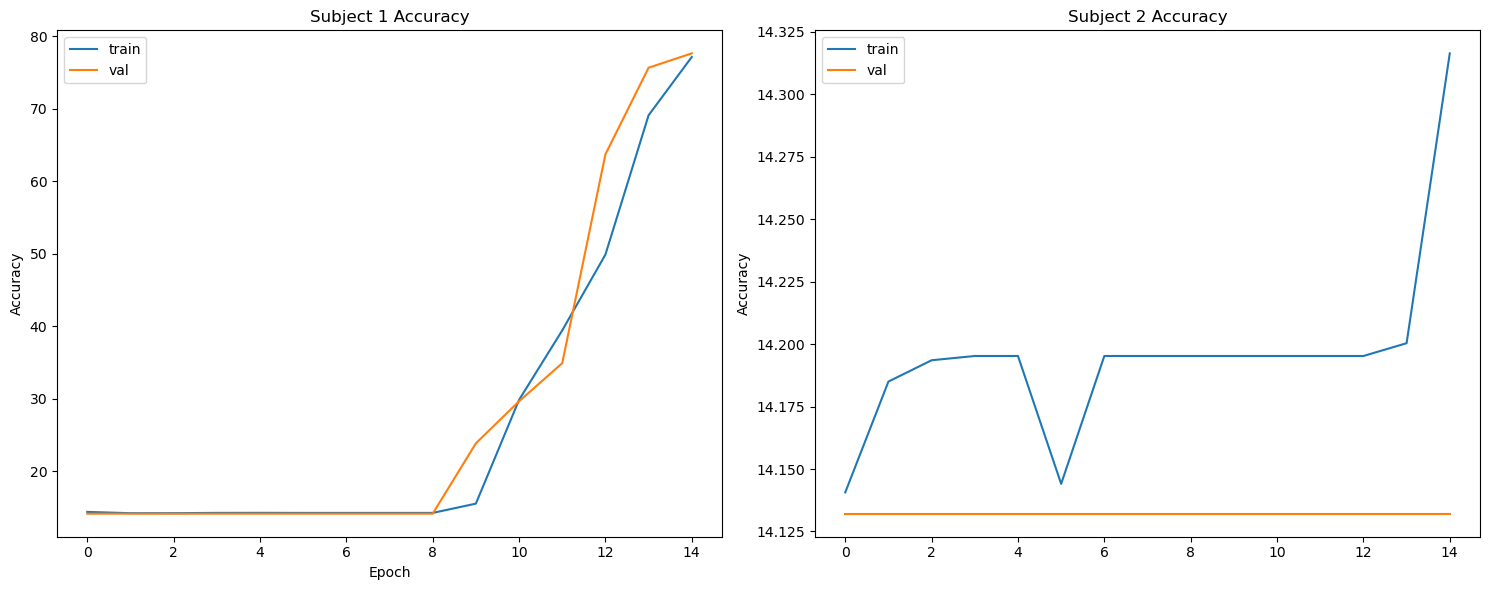

In [95]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=64, Decay=0.1

In [97]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.1)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.1)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 14.01%, Validation Accuracy: 14.13%, Epoch Time: 10321.2428ms
Epoch [2/15], Train Accuracy: 14.06%, Validation Accuracy: 14.13%, Epoch Time: 10227.4513ms
Epoch [3/15], Train Accuracy: 14.07%, Validation Accuracy: 14.13%, Epoch Time: 10297.7579ms
Epoch [4/15], Train Accuracy: 14.07%, Validation Accuracy: 14.13%, Epoch Time: 10229.4500ms
Epoch [5/15], Train Accuracy: 14.07%, Validation Accuracy: 14.13%, Epoch Time: 10299.7522ms
Epoch [6/15], Train Accuracy: 14.06%, Validation Accuracy: 14.13%, Epoch Time: 10244.1921ms
Epoch [7/15], Train Accuracy: 14.07%, Validation Accuracy: 14.13%, Epoch Time: 9588.0461ms
Epoch [8/15], Train Accuracy: 14.07%, Validation Accuracy: 14.13%, Epoch Time: 8957.0711ms
Epoch [9/15], Train Accuracy: 14.07%, Validation Accuracy: 14.13%, Epoch Time: 9021.5099ms
Epoch [10/15], Train Accuracy: 14.07%, Validation Accuracy: 14.13%, Epoch Time: 8939.5909ms
Epoch [11/15], Train Accuracy: 14.07%, Validation Accuracy: 1

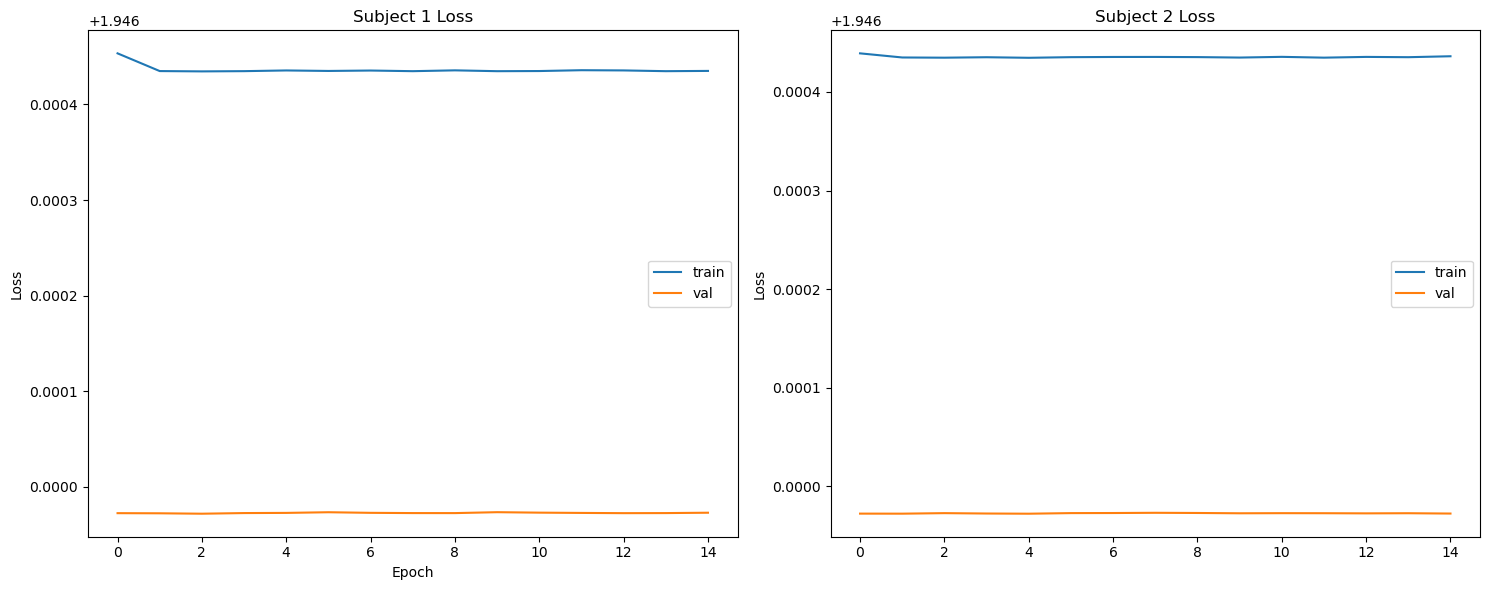

In [98]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

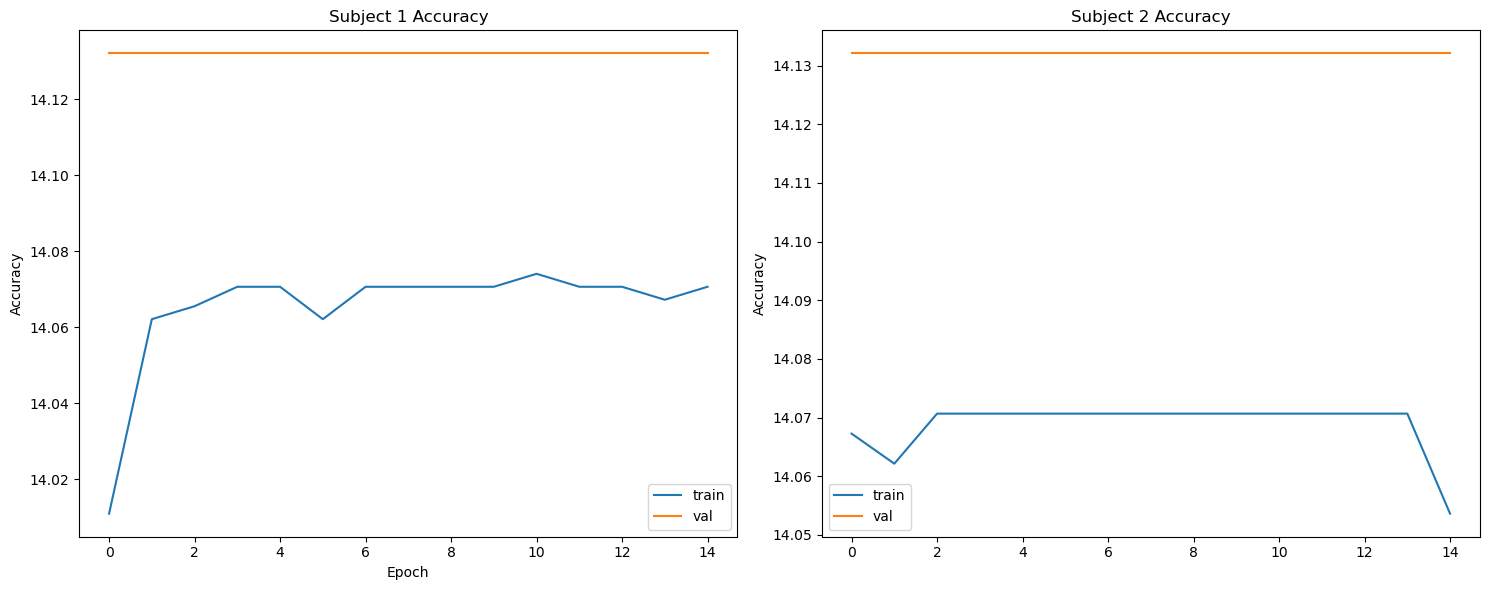

In [99]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=64, Decay=0.01

In [100]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.01)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.01)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 14.22%, Validation Accuracy: 14.13%, Epoch Time: 10586.9150ms
Epoch [2/15], Train Accuracy: 14.21%, Validation Accuracy: 14.13%, Epoch Time: 10337.7581ms
Epoch [3/15], Train Accuracy: 14.12%, Validation Accuracy: 14.13%, Epoch Time: 10223.4480ms
Epoch [4/15], Train Accuracy: 14.08%, Validation Accuracy: 14.13%, Epoch Time: 10252.9099ms
Epoch [5/15], Train Accuracy: 14.18%, Validation Accuracy: 14.13%, Epoch Time: 10281.2059ms
Epoch [6/15], Train Accuracy: 14.15%, Validation Accuracy: 14.13%, Epoch Time: 10235.1069ms
Epoch [7/15], Train Accuracy: 14.16%, Validation Accuracy: 14.13%, Epoch Time: 10282.9180ms
Epoch [8/15], Train Accuracy: 14.19%, Validation Accuracy: 14.13%, Epoch Time: 10294.2760ms
Epoch [9/15], Train Accuracy: 14.19%, Validation Accuracy: 14.13%, Epoch Time: 10384.0082ms
Epoch [10/15], Train Accuracy: 14.17%, Validation Accuracy: 14.13%, Epoch Time: 10415.0419ms
Epoch [11/15], Train Accuracy: 14.14%, Validation Accurac

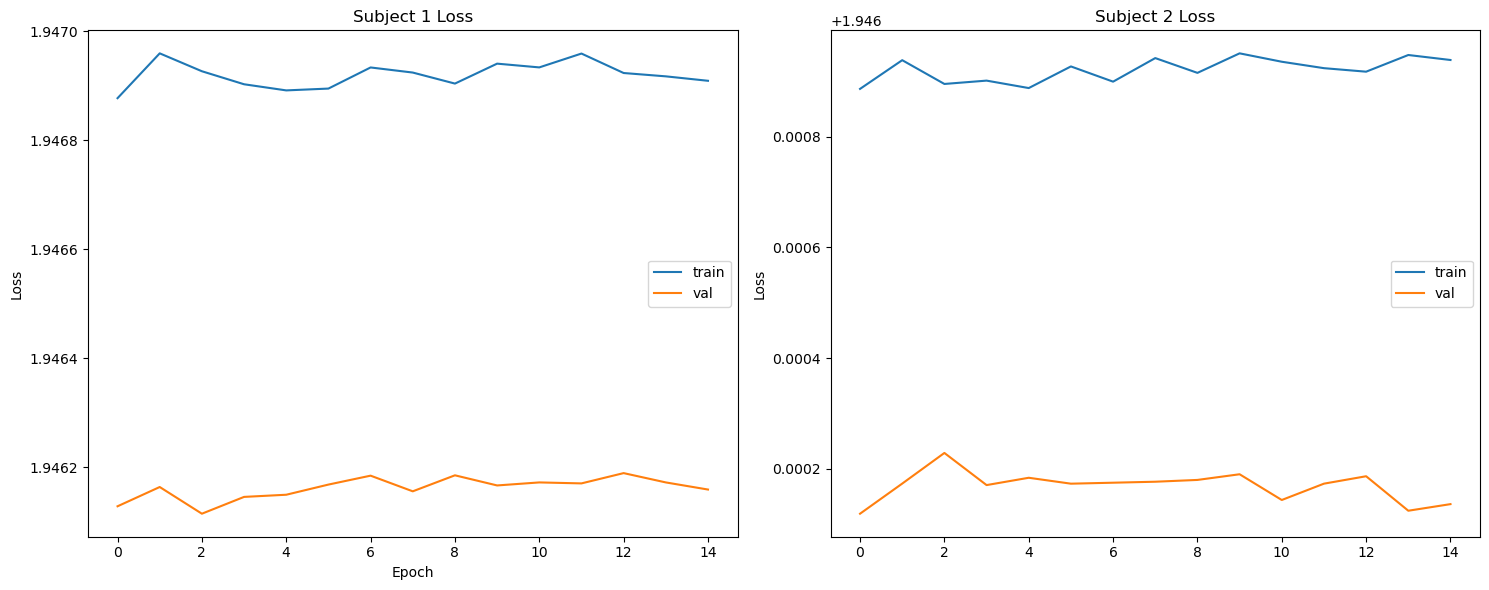

In [101]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

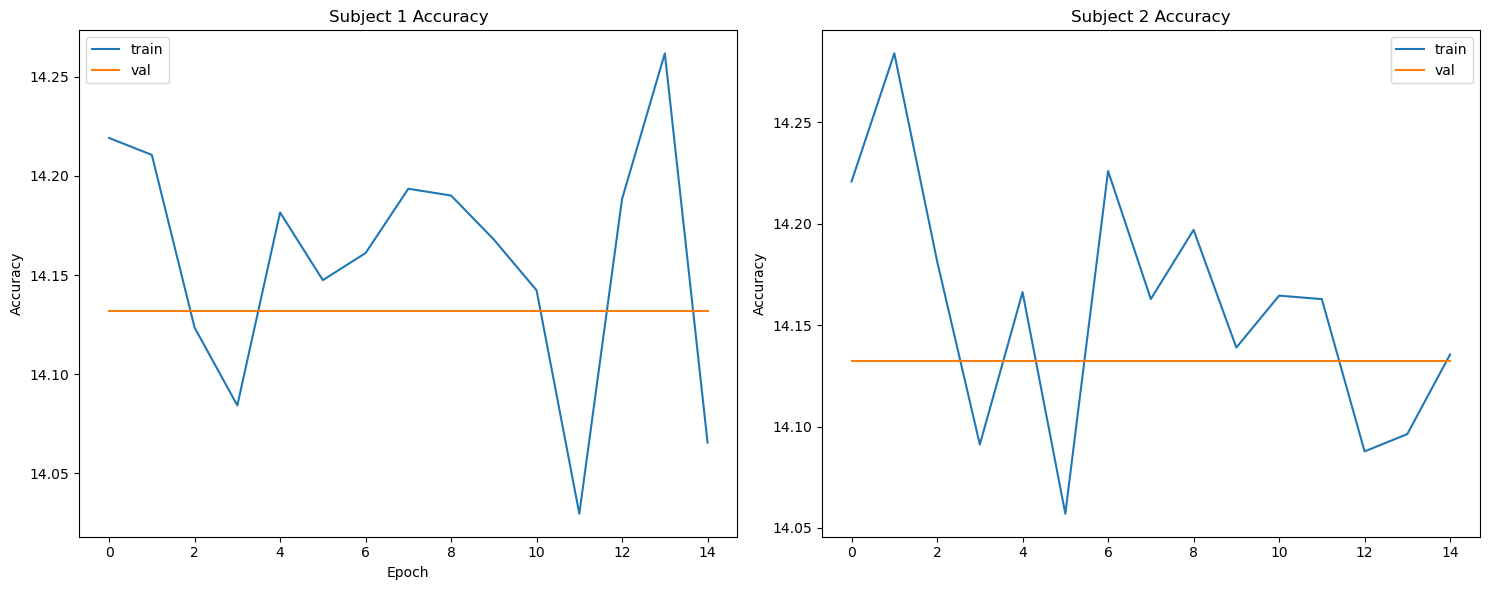

In [102]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=64, Decay=0.001

In [107]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 14.28%, Validation Accuracy: 14.65%, Epoch Time: 10406.1470ms
Epoch [2/15], Train Accuracy: 14.06%, Validation Accuracy: 14.13%, Epoch Time: 10192.8670ms
Epoch [3/15], Train Accuracy: 14.28%, Validation Accuracy: 14.13%, Epoch Time: 10340.3831ms
Epoch [4/15], Train Accuracy: 14.22%, Validation Accuracy: 14.65%, Epoch Time: 10343.2093ms
Epoch [5/15], Train Accuracy: 14.16%, Validation Accuracy: 14.65%, Epoch Time: 10452.8289ms
Epoch [6/15], Train Accuracy: 14.10%, Validation Accuracy: 14.65%, Epoch Time: 10289.9270ms
Epoch [7/15], Train Accuracy: 14.19%, Validation Accuracy: 14.65%, Epoch Time: 10371.5529ms
Epoch [8/15], Train Accuracy: 14.20%, Validation Accuracy: 14.65%, Epoch Time: 10500.3591ms
Epoch [9/15], Train Accuracy: 14.16%, Validation Accuracy: 14.65%, Epoch Time: 10351.1879ms
Epoch [10/15], Train Accuracy: 14.14%, Validation Accuracy: 14.65%, Epoch Time: 10398.3419ms
Epoch [11/15], Train Accuracy: 14.19%, Validation Accurac

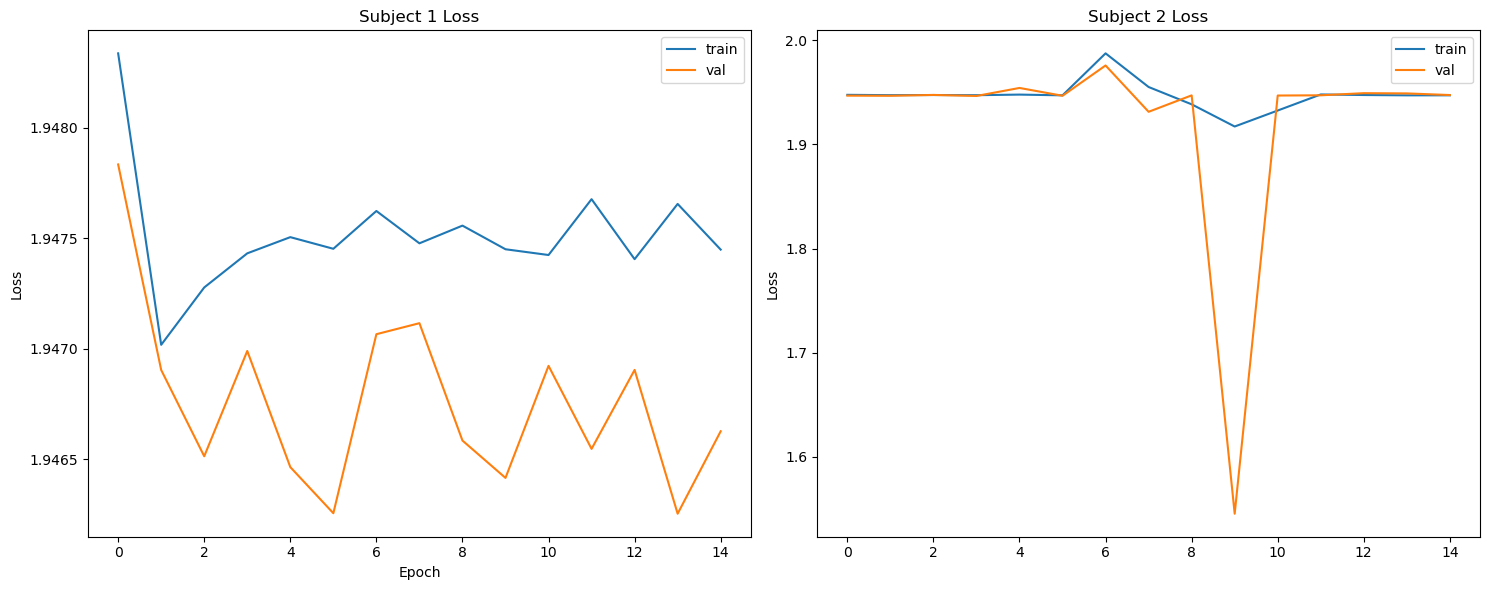

In [108]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

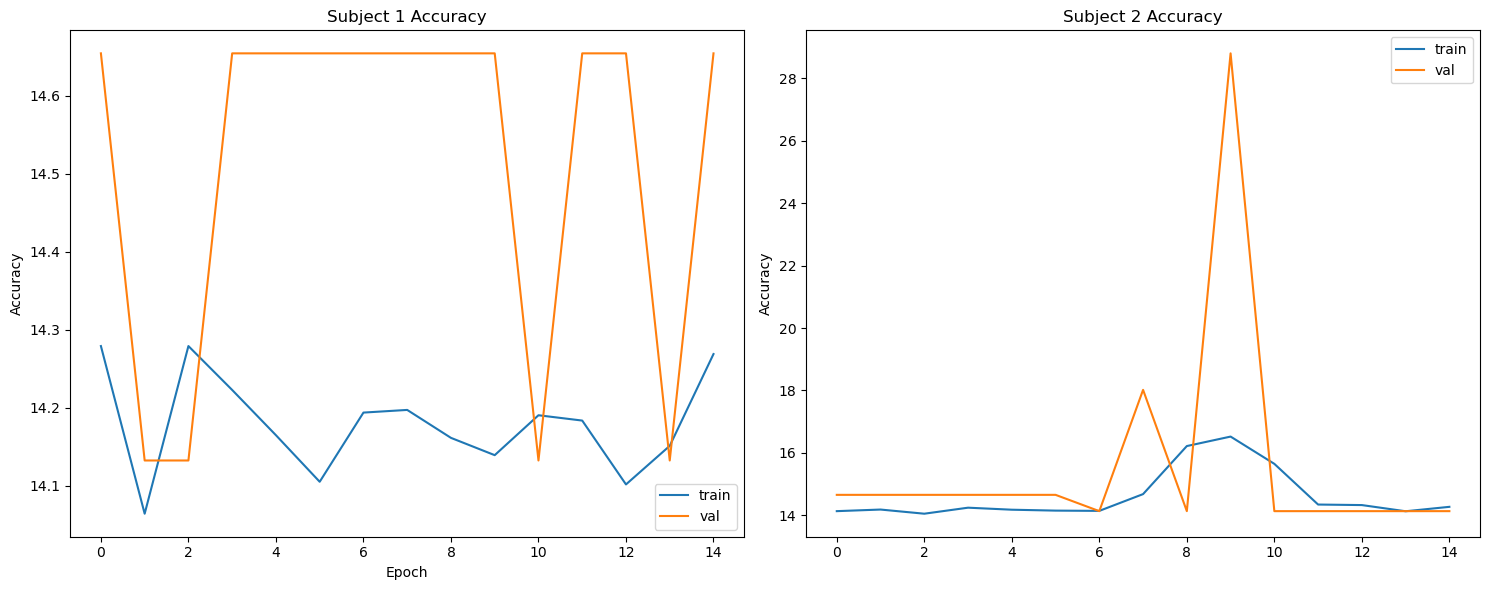

In [109]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=64, Decay=0.0001

In [110]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.0001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.0001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 16.56%, Validation Accuracy: 15.88%, Epoch Time: 10418.4501ms
Epoch [2/15], Train Accuracy: 17.18%, Validation Accuracy: 16.01%, Epoch Time: 10063.1542ms
Epoch [3/15], Train Accuracy: 17.40%, Validation Accuracy: 16.42%, Epoch Time: 10257.2641ms
Epoch [4/15], Train Accuracy: 17.81%, Validation Accuracy: 16.88%, Epoch Time: 10398.5453ms
Epoch [5/15], Train Accuracy: 18.85%, Validation Accuracy: 19.86%, Epoch Time: 10530.0572ms
Epoch [6/15], Train Accuracy: 18.25%, Validation Accuracy: 16.93%, Epoch Time: 10231.0431ms
Epoch [7/15], Train Accuracy: 19.04%, Validation Accuracy: 15.25%, Epoch Time: 10125.8569ms
Epoch [8/15], Train Accuracy: 15.37%, Validation Accuracy: 15.30%, Epoch Time: 10189.8260ms
Epoch [9/15], Train Accuracy: 15.46%, Validation Accuracy: 15.79%, Epoch Time: 10148.4919ms
Epoch [10/15], Train Accuracy: 16.20%, Validation Accuracy: 16.16%, Epoch Time: 10135.2739ms
Epoch [11/15], Train Accuracy: 17.41%, Validation Accurac

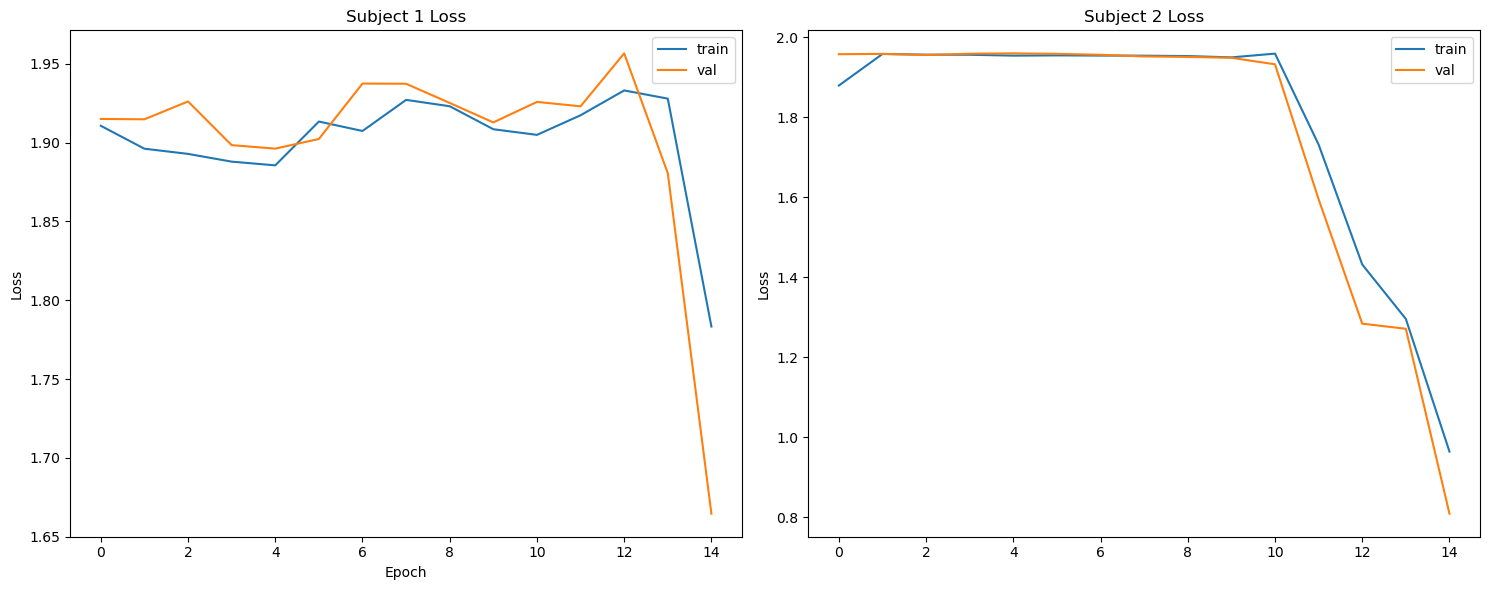

In [111]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

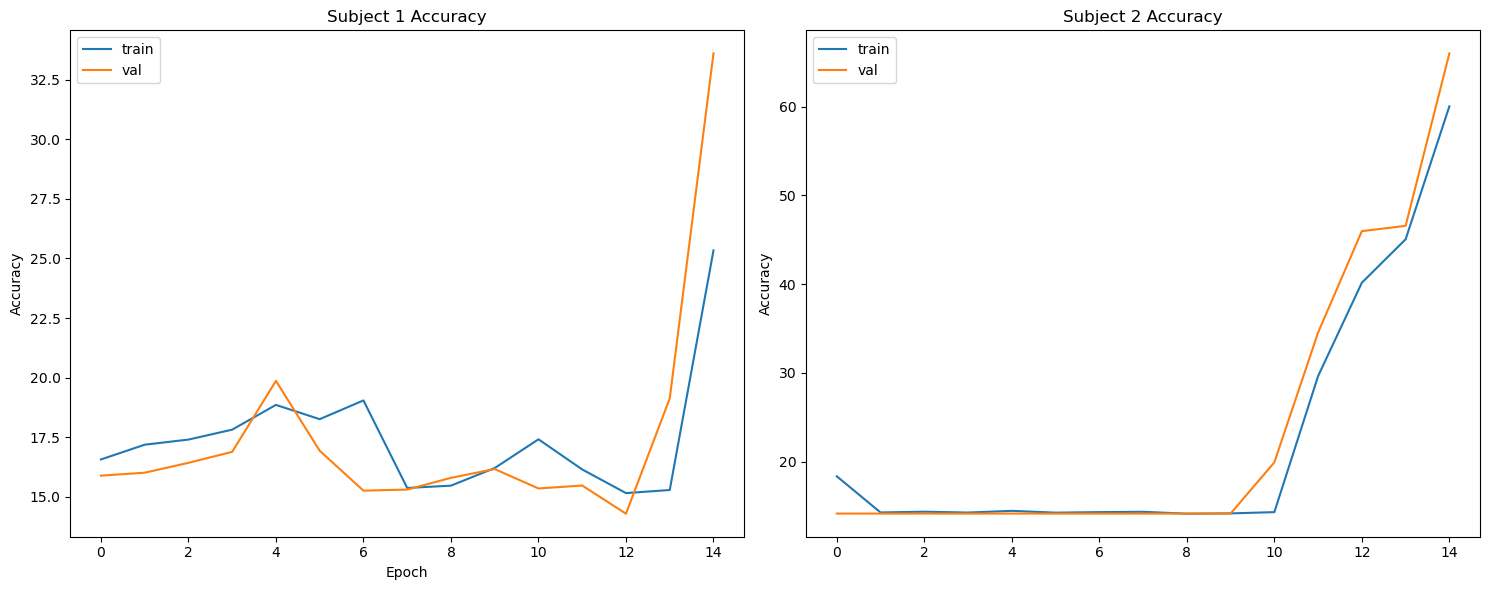

In [112]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=64, Decay=0.00001

In [113]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.00001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.00001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 49.41%, Validation Accuracy: 88.34%, Epoch Time: 10571.2919ms
Epoch [2/15], Train Accuracy: 94.65%, Validation Accuracy: 96.80%, Epoch Time: 10421.4981ms
Epoch [3/15], Train Accuracy: 97.20%, Validation Accuracy: 98.03%, Epoch Time: 10383.6212ms
Epoch [4/15], Train Accuracy: 97.83%, Validation Accuracy: 98.34%, Epoch Time: 10612.8442ms
Epoch [5/15], Train Accuracy: 98.25%, Validation Accuracy: 98.25%, Epoch Time: 10463.8557ms
Epoch [6/15], Train Accuracy: 98.53%, Validation Accuracy: 98.73%, Epoch Time: 10356.4541ms
Epoch [7/15], Train Accuracy: 98.69%, Validation Accuracy: 98.69%, Epoch Time: 9337.4200ms
Epoch [8/15], Train Accuracy: 98.90%, Validation Accuracy: 99.29%, Epoch Time: 9354.9540ms
Epoch [9/15], Train Accuracy: 99.00%, Validation Accuracy: 99.22%, Epoch Time: 9360.9941ms
Epoch [10/15], Train Accuracy: 99.23%, Validation Accuracy: 99.11%, Epoch Time: 9209.5900ms
Epoch [11/15], Train Accuracy: 99.23%, Validation Accuracy: 9

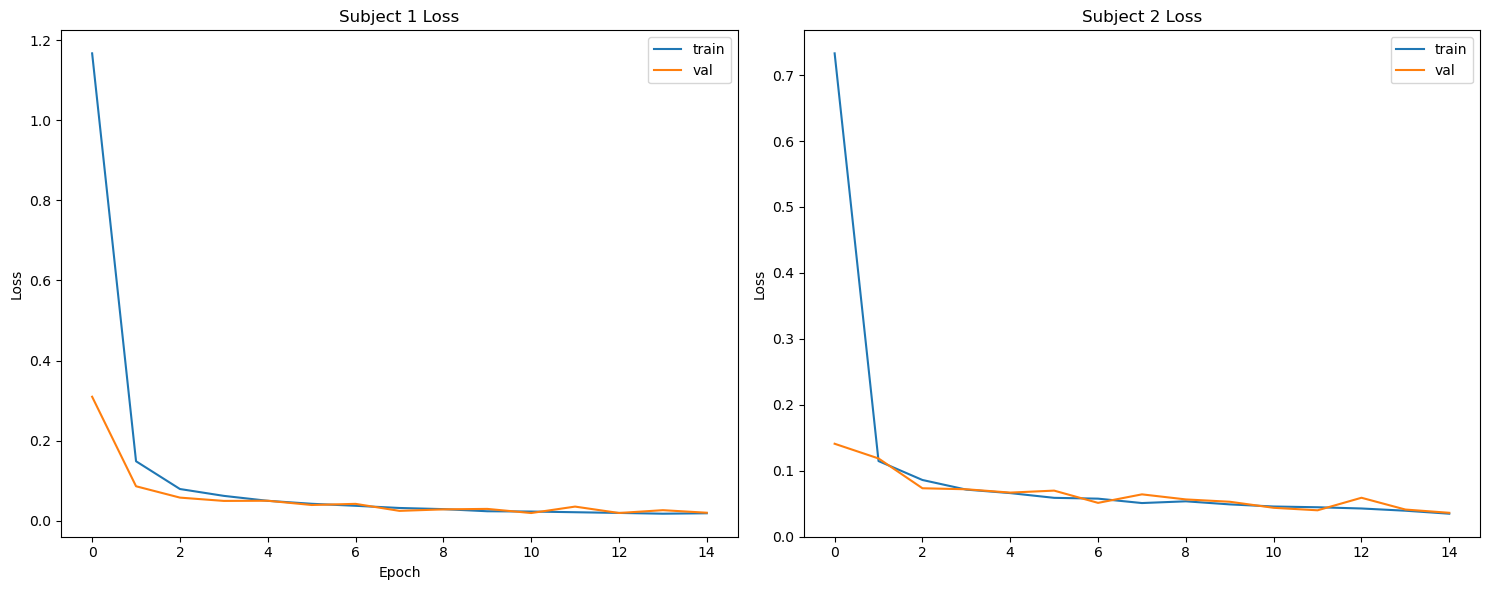

In [114]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

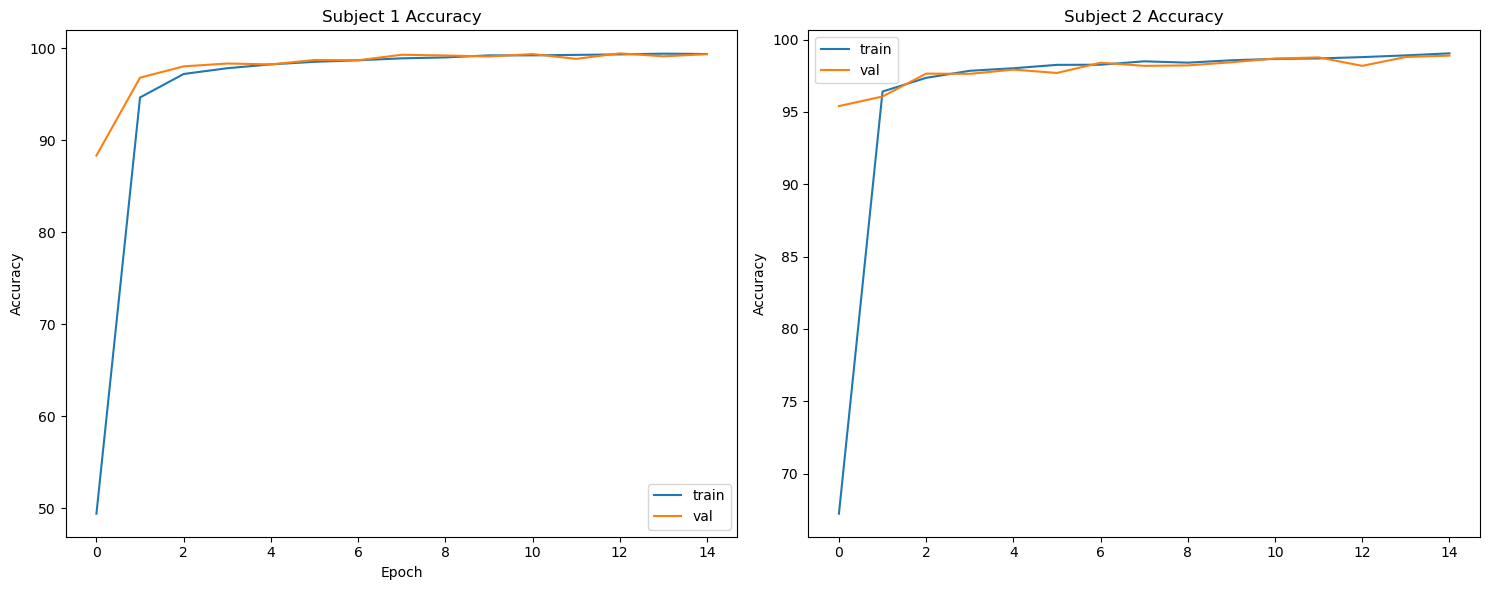

In [115]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=64, Decay=0.000001

In [119]:
print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.000001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, optimizer1)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.000001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, optimizer2)

Training on Subject 1
Epoch [1/15], Train Accuracy: 49.96%, Validation Accuracy: 68.14%, Epoch Time: 9184.1528ms
Epoch [2/15], Train Accuracy: 74.71%, Validation Accuracy: 80.98%, Epoch Time: 9128.3200ms
Epoch [3/15], Train Accuracy: 84.89%, Validation Accuracy: 90.02%, Epoch Time: 9177.7611ms
Epoch [4/15], Train Accuracy: 92.41%, Validation Accuracy: 93.38%, Epoch Time: 9181.1061ms
Epoch [5/15], Train Accuracy: 94.10%, Validation Accuracy: 94.49%, Epoch Time: 9195.5841ms
Epoch [6/15], Train Accuracy: 94.60%, Validation Accuracy: 94.18%, Epoch Time: 9147.2549ms
Epoch [7/15], Train Accuracy: 95.15%, Validation Accuracy: 94.47%, Epoch Time: 9818.2969ms
Epoch [8/15], Train Accuracy: 95.40%, Validation Accuracy: 95.38%, Epoch Time: 9181.2270ms
Epoch [9/15], Train Accuracy: 95.75%, Validation Accuracy: 95.55%, Epoch Time: 9097.1801ms
Epoch [10/15], Train Accuracy: 95.84%, Validation Accuracy: 95.28%, Epoch Time: 10477.9871ms
Epoch [11/15], Train Accuracy: 96.03%, Validation Accuracy: 95.30%

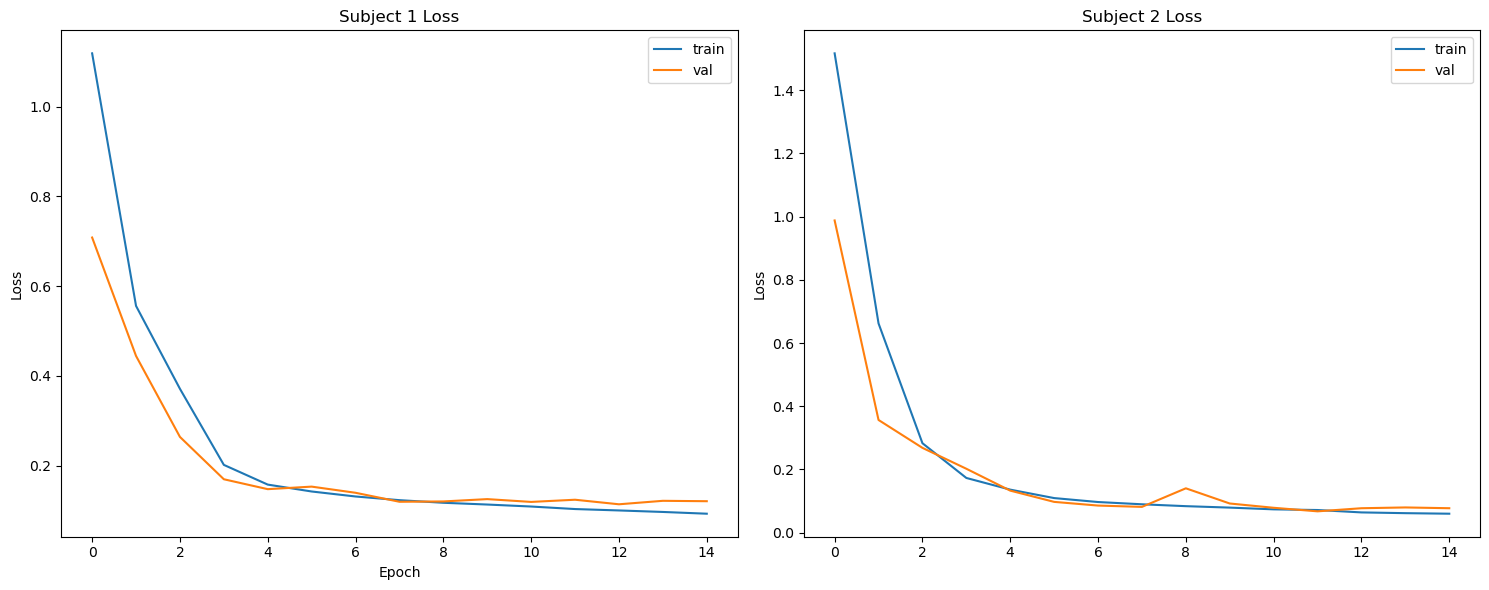

In [120]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

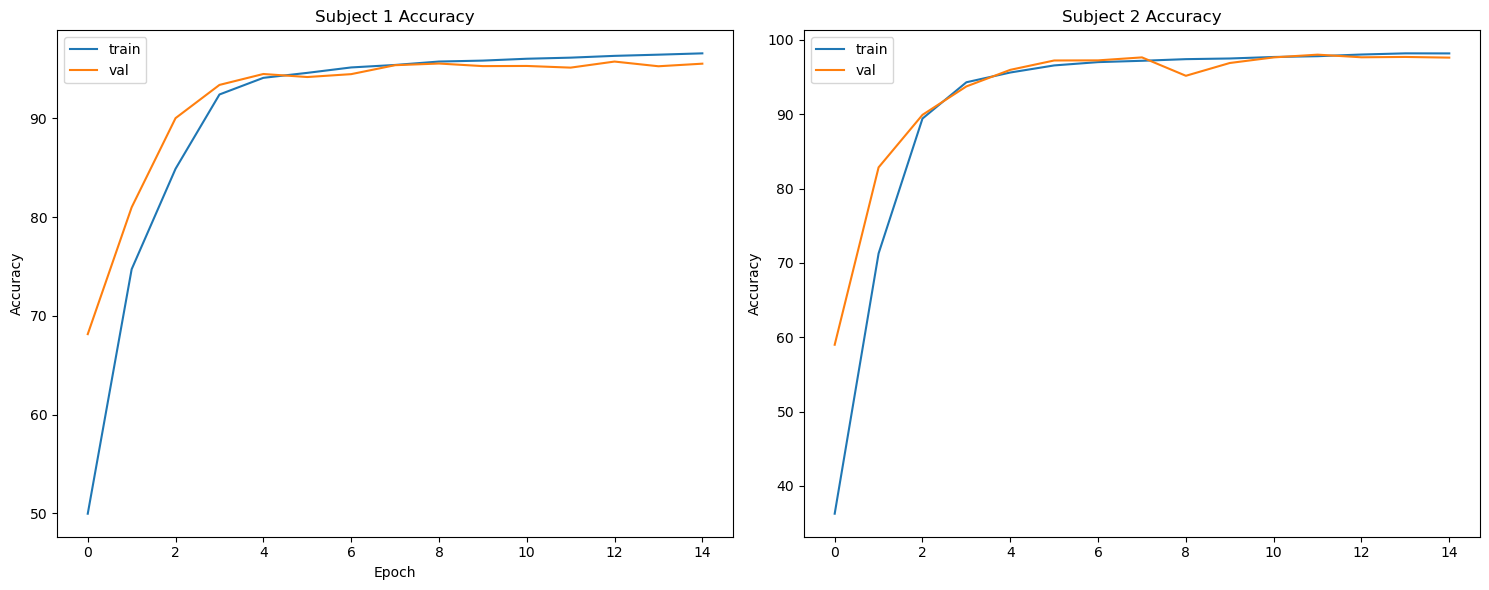

In [121]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Architecture 6 + Hyper: LR=0.01, Batch=128, Decay=0.00001

In [123]:
batch_size = 128

print('Training on Subject 1')
print('=====================')
model1 = LSTM()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.00001)

model1, train_loss1, train_acc1, val_loss1, val_acc1, ttime1, itime1 = train_model(model1, train1_set, val1_set, criterion1, 
                                                                                   optimizer1, batch_size=batch_size)

print('Training on Subject 2')
print('=====================')
model2 = LSTM()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.00001)

model2, train_loss2, train_acc2, val_loss2, val_acc2, ttime2, itime2 = train_model(model2, train2_set, val2_set, criterion2, 
                                                                                   optimizer2, batch_size=batch_size)

Training on Subject 1
Epoch [1/15], Train Accuracy: 26.93%, Validation Accuracy: 16.59%, Epoch Time: 5569.9420ms
Epoch [2/15], Train Accuracy: 30.95%, Validation Accuracy: 49.40%, Epoch Time: 5601.4931ms
Epoch [3/15], Train Accuracy: 56.47%, Validation Accuracy: 61.74%, Epoch Time: 5600.8101ms
Epoch [4/15], Train Accuracy: 68.08%, Validation Accuracy: 62.84%, Epoch Time: 5596.6642ms
Epoch [5/15], Train Accuracy: 77.84%, Validation Accuracy: 83.09%, Epoch Time: 5586.0558ms
Epoch [6/15], Train Accuracy: 86.70%, Validation Accuracy: 88.14%, Epoch Time: 5557.4498ms
Epoch [7/15], Train Accuracy: 87.89%, Validation Accuracy: 89.19%, Epoch Time: 5542.4063ms
Epoch [8/15], Train Accuracy: 89.07%, Validation Accuracy: 88.68%, Epoch Time: 5592.2129ms
Epoch [9/15], Train Accuracy: 90.26%, Validation Accuracy: 90.46%, Epoch Time: 5625.7658ms
Epoch [10/15], Train Accuracy: 91.05%, Validation Accuracy: 92.29%, Epoch Time: 5868.3841ms
Epoch [11/15], Train Accuracy: 91.65%, Validation Accuracy: 90.69%,

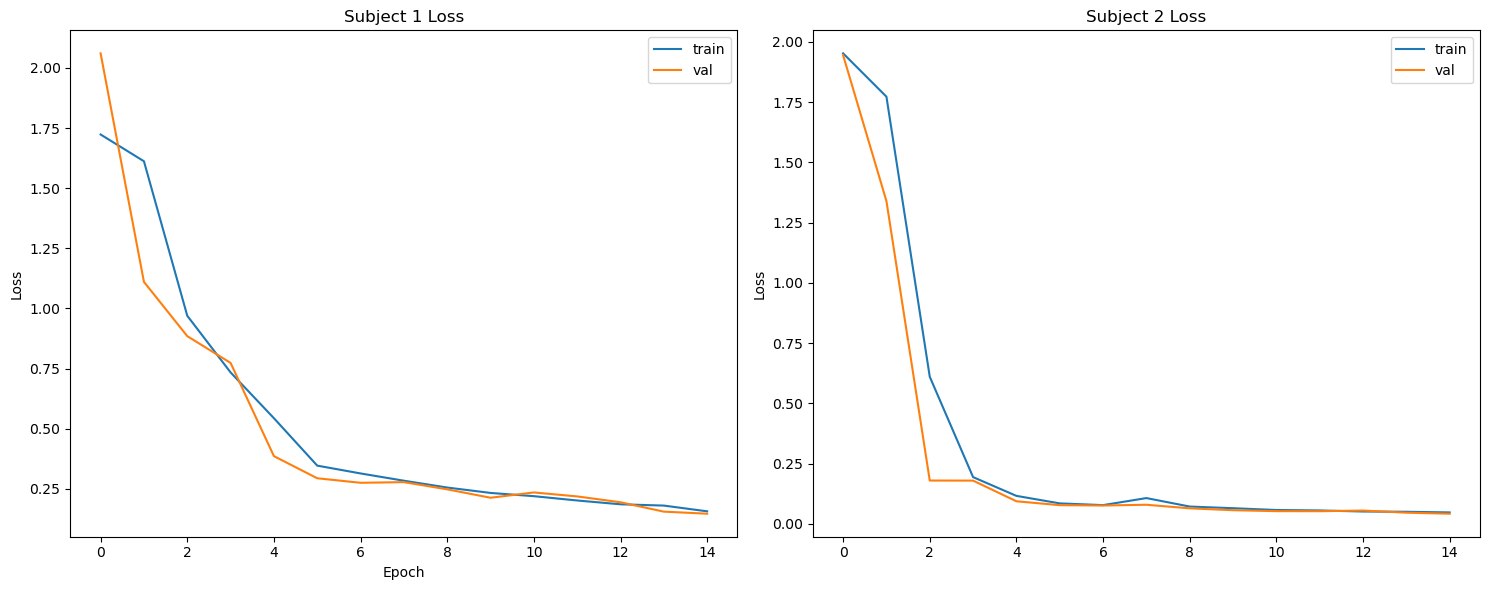

In [124]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_loss1, label='train')
ax1.plot(val_loss1, label='val')
ax1.set_title('Subject 1 Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for the second pair
ax2.plot(train_loss2, label='train')
ax2.plot(val_loss2, label='val')
ax2.set_title('Subject 2 Loss')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

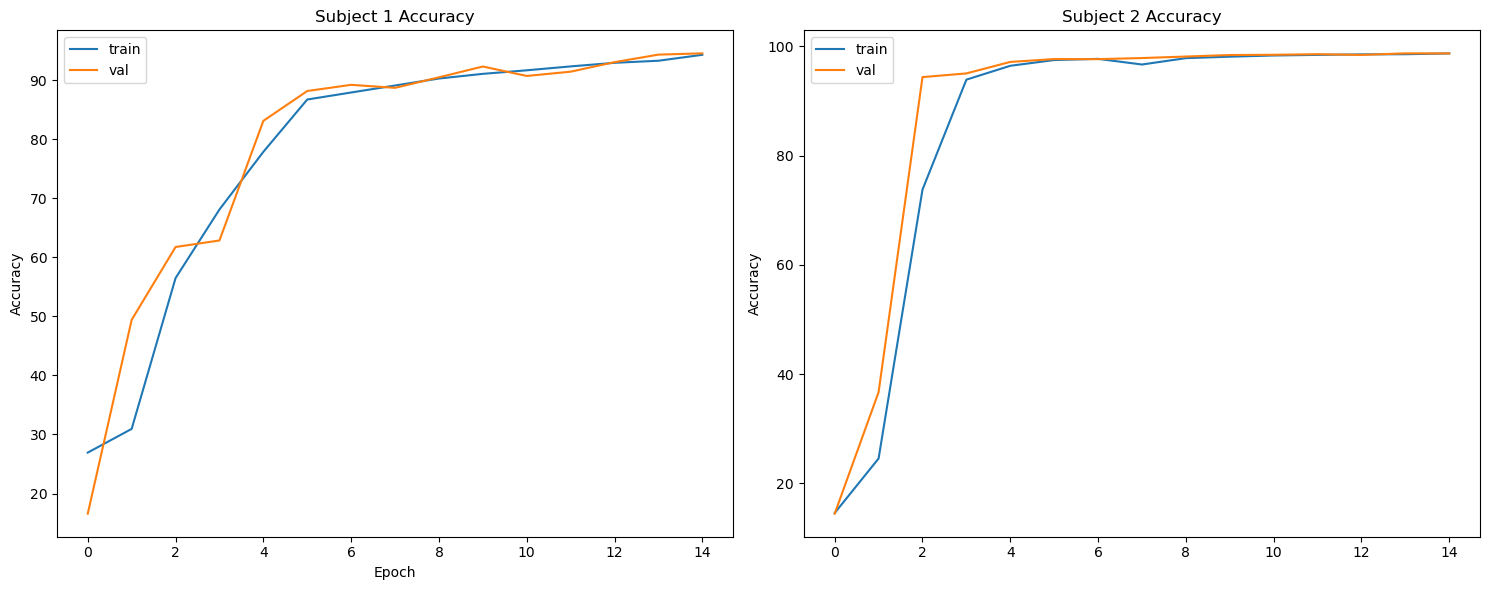

In [125]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the first pair
ax1.plot(train_acc1, label='train')
ax1.plot(val_acc1, label='val')
ax1.set_title('Subject 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot for the second pair
ax2.plot(train_acc2, label='train')
ax2.plot(val_acc2, label='val')
ax2.set_title('Subject 2 Accuracy')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Model Evaluation

In [9]:
subjects = ['sub0' + str(i) for i in range(1, 8)]
days = ['D' + str(i) for i in range(1, 16)]
sessions = ['S1', 'S2']

In [10]:
def prepare_training(train_df, test_df):
    device = 'mps'
    
    X1_train = torch.FloatTensor(np.stack(train_df.window_emg.to_numpy())).to(device)
    X1_test = torch.FloatTensor(np.stack(test_df.window_emg.to_numpy())).to(device)
    y1_train = torch.FloatTensor(train_df.label.to_numpy()).to(device)
    y1_test = torch.FloatTensor(test_df.label.to_numpy()).to(device)

    train_set = TensorDataset(X1_train, y1_train)
    val_set = TensorDataset(X1_test, y1_test)

    return train_set, val_set

### Checking with Small Data

In [351]:
a = df[(df.subject == 'sub01') & (df.day == 'D1') & (df.repetition != 10)]
b = df[(df.subject == 'sub01') & (df.day == 'D1') & (df.repetition == 10)]

In [352]:
a_set, b_set = prepare_training(a, b)

In [364]:
m = LSTM(num_layers=1, hidden_size=32)
c = nn.CrossEntropyLoss()
o = optim.SGD(m.parameters(), lr=0.001)
m, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(m, a_set, b_set, c, o, num_epochs=50)

Epoch [1/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 569.2821ms
Epoch [2/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 340.5142ms
Epoch [3/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 334.4190ms
Epoch [4/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 339.8302ms
Epoch [5/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 339.7079ms
Epoch [6/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 334.2240ms
Epoch [7/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 355.6252ms
Epoch [8/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 330.2400ms
Epoch [9/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 348.4652ms
Epoch [10/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 336.0050ms
Epoch [11/50], Train Accuracy: 14.29%, Validation Accuracy: 14.29%, Epoch Time: 359.1459ms
Epoch [1

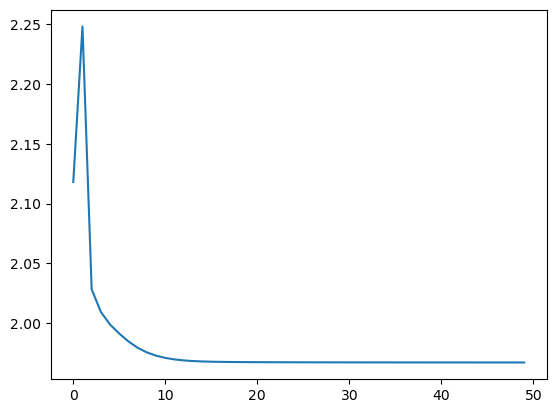

In [358]:
plt.plot(train_loss)

### Within-Session Analysis

In [ ]:
ws_df = pd.DataFrame(columns=['subject', 'day', 'session', 'performance_cv', 'train_time', 'inference_time'])

# Analyse for each subject
for sub in tqdm(subjects):
    sub_df = df[df.subject == sub]
    
    # Analyse each session in each day
    for day in tqdm(days):
        day_df = sub_df[sub_df.day == day]

        for sess in sessions:
            sess_df = day_df[day_df.session == sess]
            accuracies = list()
            train_times = list()
            inf_times = list()
            
            # Cross-validate 10 folds for each session
            for i in range(1, 11):
                # Devide test and train dataset
                train_df = sess_df[sess_df.repetition != i]
                test_df = sess_df[sess_df.repetition == i]

                # Set up dataset
                train_set, val_set = prepare_training(train_df, test_df)

                # Train Classifier
                model = CNN()
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
                model, train_loss, train_acc, val_loss, val_acc, ttime, itime = train_model(model, train_set, val_set, 
                                                                                            criterion, optimizer, verbose=False)
                train_times.append(ttime) # average across all epochs
                inf_times.append(itime) # average across all epochs
                accuracies.append(val_acc[-1])

            ws_df.loc[len(ws_df)] = [sub, day, sess, accuracies, train_times, inf_times]